# Предсказание покупательской активности пользователей интернет-магазина

## <u>Введение</u>

Интернет-магазин собирает историю покупателей, проводит рассылки предложений и
планирует будущие продажи. Для оптимизации процессов необходимо выделить пользователей,
которые готовы совершить покупку в ближайшее время.

**Цель проекта**
Предсказать вероятность покупки в течение 90 дней.

**Задачи**
- Изучить данные
- Разработать полезные признаки
- Создать модель для классификации пользователей
- Улучшить модель и максимизировать метрику roc_auc
- Выполнить тестирование

**Данные**
1. ```apparel-purchases``` -- история покупок
    - `client_id` -- идентификатор пользователя
    - `quantity` -- количество товаров в заказе
    - `price` -- цена товара
    - `category_ids` -- вложенные категории, к которым отнсится товар
    - `date` -- дата покупки
    - `message_id` -- идентификатор сообщения из рассылки

2. ```apparel-messages``` -- история рекламных рассылок
    - `bulk_campaign_id` -- идентификатор рекламной кампании
    - `client_id` -- идентификатор пользователя
    - `message_id` -- идентификатор сообщений
    - `event` -- тип действия
    - `channel` -- канал рассылки
    - `date` -- дата рассылки
    - `created_at` -- точное время создания сообщения
3. ```apparel-target_binary``` -- совершит ли клиент покупку в течение следующих 90 дней
    - `client_id` -- идентификатор пользователя
    - `target` -- целевой признак

4. ```full_campaign_daily_event``` -- агрегация общей базы рассылок по дням и типам событий
    - `date` -- дата
    - `bulk_campaign_id` -- идентификатор рассылки
    - `count_event*` -- общее количество каждого события `event`
    - `nunique_event*` -- количество уникальных `client_id` в каждом событии
5. ```full_campaign_daily_event_channel``` -- агрегация по дням с учетом событий и каналов рассылки
    - `date` -- дата
    - `bulk_campaign_id` -- идентификатор рассылки
    - `count_event*_channel*` -- общее количество каждого события по каналам
    - `nunique_event*_channel*` -- количество уникальных client_id по событиям и каналам

    $^{*}$ в именах колонок все типы событий `event`

## <u>Импорт библиотек</u>

### Библиотеки

In [54]:
# импорт библиотек
import pandas as pd
import numpy as np
import re
import phik
import time
from typing import List
from ast import literal_eval
from collections import Counter

# графика
import matplotlib.pyplot as plt
import seaborn as sns


# модели
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# выборки
from sklearn.model_selection import train_test_split

# предобработка
from sklearn.preprocessing import (StandardScaler, 
                                   MinMaxScaler, 
                                   RobustScaler)

from sklearn.impute import SimpleImputer

# пайплайны
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# метрика
from sklearn.metrics import (accuracy_score, 
                            precision_score, 
                            recall_score, 
                            f1_score, 
                            roc_auc_score,
                            average_precision_score,
                            confusion_matrix,
                            precision_recall_curve,
                            make_scorer, 
                            fbeta_score)

# подбор гиперпараметров RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

# анализ временных рядов
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics import tsaplots
from statsmodels.tsa.stattools import acf
import numpy as np

# для оценки важности признаков
import shap

# предупреждения
import warnings

### Глобальные переменные и настройки

In [55]:
# для локального выполнения -- решение проблемы с кирилицей в путях
import tempfile
tempfile.tempdir = 'C:/temp'

In [56]:
# уберем предупреждения
warnings.filterwarnings(action="ignore")

In [57]:
# ratio тестовой выборки
TEST_SIZE = 0.25

# random seed константа -- проект начат 24.11.2025
RANDOM_STATE = 241125

In [58]:
# снимем ограничение на выводимое кол-во столбцов
pd.options.display.max_columns = None
pd.options.display.max_rows = None

## <u>Вспомогательные функции</u>

**Комментарий**: ниже представлены вспомогательные функции, которые разрабатывались и затем дорабатывались в рамках предыдущих проектов.

### Функция ```dataset_info```

In [59]:
# функция вывода общей информации о датасете
def dataset_info(data):
    """
    Функция выводит информацию о датафрейме info, describe, первые и последние 5 записей
    
    Параметры:
    ----------
        data -- датафрейм
    
    Возвращает:
    -----------
        None
    """
    print("Общая информация о датасете:")
    data.info();
    print("Описательная статистика датасета:")
    display(data.describe())
    print("Первые 5 записей:")
    display(data.head())
    print("Последние 5 записей:")
    display(data.tail())

### Функция ```plot_isna```

In [60]:
# функция для отображения количества пропусков в процентном соотношении от общего числа записей
def plot_isna(data):
    try:
        # вычисляем процент пропусков
        missing_data = data.isna().mean() * 100
        # фильтруем столбцы с пропусками и сортируем
        missing_data = missing_data[missing_data > 0].sort_values(ascending=True)
        
        if missing_data.empty:
            print('Пропуски в данных отсутствуют.')
            return
        
        # создаем горизонтальную столбчатую диаграмму
        fig, ax = plt.subplots(figsize=(13, 6))
        ax.barh(missing_data.index, missing_data, color='skyblue', edgecolor='black')
        
        # настраиваем подписи и заголовок
        ax.set_title('% пропусков в данных по столбцам\n(от общего количества записей в данных)', fontsize=14)
        ax.set_xlabel('Пропуски в данных, (%)', fontsize=12)
        ax.set_ylabel('Столбцы', fontsize=12)
        
        # настраиваем шрифт для меток на осях
        ax.tick_params(axis='both', labelsize=12)
        
        # добавляем сетку
        ax.grid(True, axis='x', linestyle='--', alpha=0.7)
        
        # строим график
        plt.show()
        print("Доля пропусков по столбцам:")
        display(missing_data)
        
    except Exception as e:
        print(f'Ошибка: {e}')

### Функция ```to_snake_case```

In [61]:
def to_snake_case(name):
    """
    Преобразует CamelCase в snake_case:
    "DateCrawled" -> "date_crawled"
    
    Параметры:
    ----------
        name -- название столбца
        
    Возвращает:
    -----------
        name -- преобразованное в snake_case из CamelCase название столбца
    """
    
    # заменяем пробелы и спецсимволы на подчеркивания
    name = re.sub(r'[\s\-()]', '_', name)
    
    # вставляем _ только между camelCase (строчная -> заглавная)
    name = re.sub(r'([a-z])([A-Z])', r'\1_\2', name)
    
    # приводим к нижнему регистру и убираем множественные подчеркивания
    name = name.lower()
    name = re.sub(r'_+', '_', name)
    
    # убираем подчеркивания в начале/конце
    return name.strip('_')

### Функция ```dataset_duplicates_info```

In [62]:
# функция для вывода общей информации о дубликатах в датафрейме
def dataset_duplicates_info(data):
    """
    Функция выводит информацию о количестве явных дубликатов в датафрейме 
    и кол-во уникальных значений в столбцах
    
    Параметры:
    ----------
        data -- датафрейм
    
    Возвращает:
    ----------- 
        None
    """
    print('Размерность данных:',data.shape)
    print(data.nunique())
    print('Количество явных дубликатов:',data.duplicated().sum())

### Функция ```get_duplicated_data```

In [63]:
# функция для вывода явных дубликатов в датафрейме по столбцу
def get_duplicated_data(data, column: str = None):
    """
    Функция возвращает данные, в которых есть явные дубликаты в столбце column
    
    Аргументы:
        data -- датафрейм
        column -- столбец, в котором ищем явные дубликаты
    
    
    Возвращает: датафрейм, который содержит записи, где в column явные дубликаты
    """
    if column is None:
        return data[data.duplicated(keep=False)]
    else:
        return data[data[column].duplicated(keep=False)]

### Функция ```remove_duplicated_data```

In [64]:
# функция для вывода явных дубликатов в датафрейме по столбцу
def remove_duplicated_data(data, column: str = None, inplace: bool = True):
    """
    Функция удаляет явные дубликаты в данных
    
    Аргументы:
        data -- датафрейм
        inplace -- флаг на удаление данных в непосредственно в исходной таблице
    
    
    Возвращает: 
        датафрейм без дубликатов если inplace=False
        None если inplace=True
    """
    print('Размерность данных до удаления дубликатов:', data.shape)
    initial_count = data.shape[0]
    
    if inplace:
        data.drop_duplicates(subset=column, inplace=True)
        removed_count = initial_count - data.shape[0]
        print(f'Удалено дубликатов: {removed_count}')
        print('Размерность данных после удаления дубликатов:', data.shape)
        return None
    else:
        result = data.drop_duplicates(subset=column)
        removed_count = initial_count - result.shape[0]
        print(f'Удалено дубликатов: {removed_count}')
        print('Размерность данных после удаления дубликатов:', result.shape)
        return result

### Функция ```plot_data_analysis```

In [65]:
# вспомогательная функция для отрисовки параметров с целью их дальнейшего анализа
# функция была написана ранее в рамках предыдущих проектов, эта версия доработанная
def plot_data_analysis(
    data,
    title: str = 'Изучение параметров',
    title_box: str = 'Диаграмма размаха',
    title_hist: str = 'Распределение',
    x_label: str = 'X',
    y_label: str = 'Y',
    plot_box: bool = True,
    plot_bar: bool = False,
    x=None,
    y=None,
    bins: int = 200,
    bar_labels=None,
    discrete=False,
    figsize=None,
    color: str = 'skyblue',
    show_stats: bool = True,
    label_angle: int = 0,
    log: bool = False
):
    """
    Функция для отрисовки данных с возможностью построения:
        boxplot (диаграмма размаха)
        гистограммы или barplot (столбчатой диаграммы)
    
    Параметры:
    ----------
        data -- данные для анализа (pd.Series, pd.DataFrame или массив)
        title -- общий заголовок
        title_box -- заголовок для boxplot
        title_hist -- заголовок для гистограммы/barplot
        x_label -- подпись оси X
        y_label -- подпись оси Y
        plot_box -- строить ли boxplot (по умолчанию True)
        plot_bar -- использовать ли barplot вместо гистограммы (по умолчанию False)
        x -- данные для оси X (если нужен barplot с внешними данными)
        y -- данные для оси Y (если нужен barplot с внешними данными)
        bins -- количество бинов для гистограммы
        bar_labels -- подписи для barplot
        discrete -- флаг для дискретных данных
        figsize -- размер графика
        color -- основной цвет графиков
        show_stats -- показывать ли статистику (по умолчанию True)
    """
    # проверка и преобразование типов ходных данных
    if not isinstance(data, (pd.Series, pd.DataFrame, np.ndarray, list)):
        raise TypeError("Данные должны быть типа pd.Series, pd.DataFrame, np.ndarray или list")
    
    if isinstance(data, (pd.DataFrame, np.ndarray, list)):
        data = pd.Series(data)
    
    # настройка размера графика
    if figsize is None:
        figsize = (13, 8) if plot_box else (13, 6)
    
    # создание subplots
    if plot_box:
        fig, (ax_box, ax_main) = plt.subplots(2, 1, figsize=figsize, 
                                             gridspec_kw={'height_ratios': [1, 2]})
        # усы
        ax_box.boxplot(data, vert=False, patch_artist=True,
                      boxprops=dict(facecolor='lightblue'))
        ax_box.set_title(title_box, pad=10)
        ax_box.set_xlabel(x_label)
        ax_box.grid(axis='x', linestyle='--', alpha=0.7)
        ax_box.set_yticks([])
    else:
        fig, ax_main = plt.subplots(1, 1, figsize=figsize)
    
    # выбор типа основного графика
    if plot_bar:
        if x is None or y is None:
            if discrete:
                value_counts = data.value_counts().sort_index()
                x = value_counts.index
                y = value_counts.values
                bar_labels = x if bar_labels is None else bar_labels
            else:
                raise ValueError("Для barplot нужно указать x и y или использовать discrete=True")
        
        ax_main.bar(x=x, height=y, color=color, edgecolor='black', alpha=0.8)
        ax_main.set_title(title_hist, pad=10)
        
        # установка подписей для дискретных данных
        if bar_labels is not None:
            ax_main.set_xticks(x if discrete else np.arange(len(x)))
            ax_main.set_xticklabels(bar_labels, rotation=label_angle, ha='right')
    else:
        # гистограмма
        ax_main.hist(data, bins=bins, color=color, edgecolor='black', alpha=0.8, log=log)
        ax_main.set_title(title_hist, pad=10)
    
    # подписи к осям и сетка
    ax_main.set_xlabel(x_label)
    ax_main.set_ylabel(y_label)
    ax_main.grid(axis='both', linestyle='--', alpha=0.5)
    
    fig.suptitle(title, fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()
    
    # вывод статистики
    if show_stats:
        display(data.describe())

### Функция ```plot_funnel```

In [66]:
def plot_funnel(
    data,
    event_column: str,
    funnel_sequence: list,
    title: str = 'Маркетинговая воронка по событиям',
    color: str = 'skyblue',
    figsize: tuple = (13, 6),
    show_percentages: bool = True,
    show_values: bool = True,
    orientation: str = 'vertical'
):
    """
    Функция для построения маркетинговой воронки из столбца с событиями
    
    Параметры:
    ----------
    data : pd.DataFrame
        Датасет с данными
    event_column : str
        Столбец с событиями (click, purchase, open, etc.)
    funnel_sequence : list
        Последовательность событий в порядке воронки
    title : str
        Заголовок графика
    color : str
        Основной цвет воронки
    figsize : tuple
        Размер графика
    show_percentages : bool
        Показывать проценты конверсии
    show_values : bool
        Показывать абсолютные значения
    orientation : str
        Ориентация воронки ('vertical' или 'horizontal')
    """
    
    # проверяем, что столбец существует
    if event_column not in data.columns:
        raise ValueError(f"Столбец '{event_column}' не найден в данных!")
    
    # считаем количество каждого события
    event_counts = data[event_column].value_counts()
    
    # собираем данные по заданной последовательности
    funnel_data = []
    for event in funnel_sequence:
        if event in event_counts.index:
            funnel_data.append(event_counts[event])
        else:
            print(f"Событие '{event}' не найдено в данных!")
            funnel_data.append(0)
    
    # считаем конверсию между этапами
    conversion_rates = []
    for i in range(1, len(funnel_data)):
        if funnel_data[i-1] > 0:
            conv_rate = (funnel_data[i] / funnel_data[i-1]) * 100
        else:
            conv_rate = 0
        conversion_rates.append(conv_rate)
    
    # создаем график
    fig, ax = plt.subplots(figsize=figsize)
    
    if orientation == 'vertical':
        # вертикальная воронка
        y_pos = np.arange(len(funnel_sequence))
        bars = ax.barh(y_pos, funnel_data, color=color, alpha=0.8, edgecolor='black')
        
        # подписи
        ax.set_yticks(y_pos)
        ax.set_yticklabels(funnel_sequence)
        ax.set_xlabel('Количество событий')
        ax.set_title(title, fontsize=14, pad=20)
        
        # добавляем значения и проценты
        for i, (bar, value) in enumerate(zip(bars, funnel_data)):
            width = bar.get_width()
            
            if value > 0:
                text_parts = []
                if show_values:
                    text_parts.append(f"{value:,}")
                if show_percentages and i > 0:
                    conv_rate = conversion_rates[i-1]
                    text_parts.append(f"{conv_rate:.1f}%")
                
                # объединяем все в одну строку над баром
                label_text = "\n".join(text_parts)
                
                ax.text(width + max(funnel_data) * 0.01, 
                       bar.get_y() + bar.get_height()/2, 
                       label_text, ha='left', va='center', fontsize=9)
    
    else:
        # горизонтальная воронка
        x_pos = np.arange(len(funnel_sequence))
        bars = ax.bar(x_pos, funnel_data, color=color, alpha=0.8, edgecolor='black')
        
        # подписи
        ax.set_xticks(x_pos)
        ax.set_xticklabels(funnel_sequence, ha='right')
        ax.set_ylabel('Количество событий')
        ax.set_title(title, fontsize=14, pad=20)
        
        # добавляем значения и проценты НАД КАЖДЫМ БАРОМ
        for i, (bar, value) in enumerate(zip(bars, funnel_data)):
            height = bar.get_height()
            
            if value > 0:
                # Формируем текст для отображения над баром
                text_parts = []
                if show_values:
                    text_parts.append(f"{value:,}")
                if show_percentages and i > 0:
                    conv_rate = conversion_rates[i-1]
                    text_parts.append(f"{conv_rate:.1f}%")
                
                # Объединяем все в одну строку над баром
                label_text = "\n".join(text_parts)
                
                # Размещаем над баром
                ax.text(bar.get_x() + bar.get_width()/2, 
                       height + max(funnel_data) * 0.02, 
                       label_text, ha='center', va='bottom', fontsize=9)
    
    ax.grid(axis='y' if orientation == 'vertical' else 'x', 
           linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # выводим статистику по воронке
    print("Статистика воронки:")
    
    for i, (stage, count) in enumerate(zip(funnel_sequence, funnel_data)):
        if i == 0:
            print(f"{stage:<25} {count:>10,}: (100.0%)")
        else:
            conv_from_previous = conversion_rates[i-1] if funnel_data[i-1] > 0 else 0
            conv_from_first = (count / funnel_data[0]) * 100 if funnel_data[0] > 0 else 0
            print(f"{stage:<25} {count:>10,}: ({conv_from_previous:3.1f}% | {conv_from_first:3.1f}%)")
    
    if funnel_data[0] > 0:
        total_conversion = (funnel_data[-1] / funnel_data[0]) * 100
        print(f"Общая конверсия: {total_conversion:.2f}%")
        print(f"Потери: {funnel_data[0] - funnel_data[-1]:,} событий")
    else:
        print("Первый этап воронки имеет 0 событий!")

### Функция ```plot_decomposition_component```

In [67]:
def plot_decomposition_component(component, title, ylabel, start_date=None, end_date=None, figsize=(13, 8)):
    """
    Построение графика компонента декомпозиции
    
    Параметры:
    ----------
    component : pd.Series
        Компонент декомпозиции (trend, seasonal, residuals)
    title : str
        Заголовок графика
    ylabel : str
        Подпись оси Y
    start_date : str, optional
        Начальная дата для отображения (формат 'YYYY-MM-DD')
    end_date : str, optional  
        Конечная дата для отображения (формат 'YYYY-MM-DD')
    figsize : tuple, optional
        Размер графика
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    # делаем срез по времени, если необходимо
    if start_date is not None and end_date is not None:
        data_to_plot = component.loc[start_date:end_date]
    else:
        data_to_plot = component
    
    # рисуем
    ax.plot(data_to_plot.index, data_to_plot.values)
    
    # тип компонента
    component_name = str(component.name).lower()
    if 'seasonal' in component_name:
        title += '\nСезонная компонента'
    elif 'trend' in component_name:
        title += '\nТрендовая компонента'
    elif 'residual' in component_name:
        title += '\nОстаточная компонента'
    else:
        ylabel = 'Значение'
    
    # Заголовок и подписи осей
    ax.set_title(title)
    ax.set_xlabel('Дата и время')
    ax.set_ylabel(ylabel)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    
    plt.show()

### Функция ```plot_corr_heatmap```

In [68]:
# функция построения тепловой карты коэффициентов корреляции Пирсона
def plot_corr_heatmap(data, 
                      title: str = 'Тепловая карта корреляции', 
                      columns: List[str] = None):
    """
    Функция для построения тепловой карты коэффициентов корреляции Пирсона
    
    Параметры:
    ----------
        data -- DataFrame
    """
    plt.figure(figsize=(18, 18))
    corr_matrix = data.phik_matrix(interval_cols=columns)
    sns.heatmap(corr_matrix, 
                annot=True,  # показывать значения в ячейках
                fmt=".2f",   # формат чисел (2 знака после запятой)
                cmap='coolwarm',  # цветовая схема
                vmin=-1, vmax=1,  # диапазон значений
                linewidths=0.5)   # ширина линий между ячейками

    # заголовок
    plt.title(title)

    # вывод графика
    plt.tight_layout()
    plt.show()
    return corr_matrix

### Функция ```plot_feature_vs_target```

In [69]:
def plot_feature_vs_target(data, 
                           feature, 
                           target,
                           x_label='Признак',
                           y_label='Количество',
                           title='Распределение признака от целевого',
                           bins=30,
                           label_angle=0,
                           scatter_alpha=0.6):
    """
    Наложенные распределения фичи по бинарному таргету со scatter plot
    
    Параметры:
    ----------
    data : DataFrame
        Датафрейм с данными
    feature : str
        Название фичи для анализа
    target : str
        Название бинарного целевого признака
    x_label: str
        Подпись оси X
    y_label: str
        Подпись оси Y
    title: str
        Заголовок графика
    bins: int
        Количество бинов для гистограммы
    label_angle: int
        Угол наклона подписей шкалы по оси X
    scatter_alpha: float
        Прозрачность точек на scatter plot
    """
    
    # cоздаем фигуру с двумя субплогами
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # разделяем данные по целевому
    data_0 = data[data[target] == 0][feature]
    data_1 = data[data[target] == 1][feature]
    
    # гистограмма/bar plot
    # непрерывных фич строим гистограммы
    if data[feature].dtype in ['int64', 'float64'] and data[feature].nunique() > 10:
        ax1.hist(data_0, alpha=0.7, label='нет риска - (0)', bins=bins, color='skyblue', edgecolor='black')
        ax1.hist(data_1, alpha=0.7, label='есть риск - (1)', bins=bins, color='salmon', edgecolor='black')
        ax1.set_ylabel(y_label)
    
    # для категориальных/дискретных - bar plot
    else:
        counts_0 = data_0.value_counts().sort_index()
        counts_1 = data_1.value_counts().sort_index()
        
        x = np.arange(len(counts_0))
        width = 0.35
        
        bars1 = ax1.bar(x - width/2, counts_0, width, label='нет риска - (0)', color='skyblue', alpha=0.8, edgecolor='black')
        bars2 = ax1.bar(x + width/2, counts_1, width, label='есть риск - (1)', color='salmon', alpha=0.8, edgecolor='black')
        
        # добавляем подписи только если не слишком много баров
        if len(counts_0) <= 20:
            ax1.bar_label(bars1, fmt='%.0f', padding=3, fontsize=8)
            ax1.bar_label(bars2, fmt='%.0f', padding=3, fontsize=8)
        
        try:
            xtick_labels = [f'{float(val):.2f}' for val in counts_0.index]
        except (ValueError, TypeError):
            xtick_labels = [str(val) for val in counts_0.index]
        ax1.set_xticks(x)
        ax1.set_xticklabels(xtick_labels, rotation=label_angle)
        ax1.set_ylabel(y_label)
    
    ax1.set_xlabel(x_label)
    ax1.set_title(f'{title}\n(Распределение)')
    ax1.legend()
    ax1.grid(alpha=0.3)
    
    # scatter plot
    if data[feature].dtype in ['int64', 'float64']:
        jitter = np.random.normal(0, 0.02, size=len(data))
        y_jitter = data[target] + jitter
        
        scatter = ax2.scatter(data[feature], y_jitter, 
                             c=data[target], alpha=scatter_alpha, 
                             cmap='coolwarm', edgecolors='black', linewidth=0.5)
        
        ax2.set_xlabel(x_label)
        ax2.set_ylabel('Целевая переменная')
        ax2.set_yticks([0, 1])
        ax2.set_yticklabels(['Нет риска (0)', 'Есть риск (1)'])
        ax2.set_title(f'{title}\n(Scatter Plot)')
        ax2.grid(alpha=0.3)
        
        # фиганем линию тренда если признак числовой
        if data[feature].nunique() > 10:
            z = np.polyfit(data[feature], data[target], 1)
            p = np.poly1d(z)
            x_range = np.linspace(data[feature].min(), data[feature].max(), 100)
            ax2.plot(x_range, p(x_range), "r--", alpha=0.8, linewidth=2, 
                    label=f'Тренд (наклон: {z[0]:.3f})')
            ax2.legend()
    
    else:
        # категориальных признаков - boxplot вместо scatter
        data_boxplot = data.copy()
        data_boxplot[target] = data_boxplot[target].astype(str)
        sns.boxplot(data=data_boxplot, x=feature, y=target, ax=ax2, palette='coolwarm')
        ax2.set_title(f'{title}\n(Box Plot)')
        ax2.set_xlabel(x_label)
        ax2.set_ylabel('Целевая переменная')
    
    plt.tight_layout()
    plt.show()
    
    # статистика
    print(f"Статистика по {feature}:")
    print(f"Уникальных значений: {data[feature].nunique()}")
    print(f"Тип данных: {data[feature].dtype}")
    
    # средние значения только для числовых фич
    if data[feature].dtype in ['int64', 'float64']:
        print(f"\nСредние значения:")
        print(f"Без риска: {data_0.mean():.3f}")
        print(f"С риском: {data_1.mean():.3f}")

        # корреляция
        correlation = data[feature].corr(data[target])
        print(f"Корреляция с целевой: {correlation:.3f}")
                
        # разница средних для количественных
        if data[feature].nunique() > 10:
            mean_diff = data_1.mean() - data_0.mean()
            print(f"Разница средних (риск - нет риска): {mean_diff:.3f}")
            print(f"Относительная разница: {mean_diff/data_0.mean():.2%}")


    # доли риска для категориальных
    if data[feature].nunique() <= 10:
        risk_ratios = data.groupby(feature)[target].mean()
        print(f"\nДоли риска по категориям {feature}:")
        for category, ratio in risk_ratios.items():
            print(f"  {category}: {ratio:.1%}")

### Функция ```corr_analysis```

In [70]:
def corr_analysis(corr_matrix, 
                  target_feature, 
                  features=None, 
                  min_abs_corr=0.1):
    """
    Анализирует корреляции целевого признака с другими признаками и сортирует их по убыванию.
    
    Параметры:
    ----------
    corr_matrix : DataFrame
        Матрица корреляции (phik-матрица или обычная корреляционная матрица)
    target_feature : str
        Название целевого признака для анализа
    features : list, optional
        Список признаков для анализа (если None, берутся все из матрицы)
    min_abs_corr : float, optional
        Минимальная абсолютная корреляция для включения в результат (по умолчанию 0.1)
        
    Возвращает:
    -----------
    DataFrame
        Таблица с признаками, отсортированными по убыванию абсолютной корреляции с целевым признаком,
        с указанием силы связи по шкале Чеддока
    """
    # если не указан список признаков, берем все из матрицы (исключая целевой)
    if features is None:
        features = [col for col in corr_matrix.columns if col != target_feature]
    
    # собираем корреляции с целевым признаком
    correlations = []
    
    for feature in features:
        if feature == target_feature:
            continue
        
        corr = corr_matrix.loc[target_feature, feature]
        abs_corr = abs(corr)
        
        # реализуем шкалу Чеддока (согласно 11 спринту - 3 тема - 9 урок)
        if abs_corr >= 0.9:
            strength = 'Весьма высокая'
        elif abs_corr >= 0.7:
            strength = 'Высокая'
        elif abs_corr >= 0.5:
            strength = 'Заметная'
        elif abs_corr >= 0.3:
            strength = 'Умеренная'
        elif abs_corr >= 0.1:
            strength = 'Слабая'
        elif abs_corr > min_abs_corr and abs_corr < 0.1:
            strength = 'Очень слабая'
        elif abs_corr < min_abs_corr:
            strength = 'Отсутствует'
        
        # определяем направление связи
        direction = 'положительная' if corr > 0 else 'отрицательная'
        
        correlations.append({
            'Признак': feature,
            'Корреляция': corr,
            'Абс. корреляция': abs_corr,
            'Сила связи': strength,
            'Направление': direction
        })
    
    # создаем DataFrame и сортируем по убыванию абсолютной корреляции
    if not correlations:
        return pd.DataFrame()  # возвращаем пустой DataFrame если нет корреляций
    
    result_df = pd.DataFrame(correlations).sort_values(
        by='Абс. корреляция', ascending=False
    ).reset_index(drop=True)
    
    # вывод корреляции для удобства чтения
    result_df['Корреляция'] = result_df['Корреляция'].apply(lambda x: f"{x:.3f}")
    
    return result_df[['Признак', 'Корреляция', 'Сила связи', 'Направление']]

### Функция ```evaluate_model```

In [71]:
def evaluate_model(model, 
                   params, 
                   model_name, 
                   X_train, 
                   y_train,
                   preprocessor_ohe,
                   preprocessor_ordinal,
                   random_state=42,
                   refit_metric='roc_auc',
                   cv=3,
                   n_iter=5):
    """
    Функция для оценки моделей бинарной классификации
    
    Параметры:
    ----------
    model: модель
    params: гиперпараметры для перебора
    model_name: название модели
    X_train: входные признаки обучающей выборки
    y_train: целевой признак обучающей выборки
    preprocessor: пайплайн для предобработки
    random_state: зерно для рандома
    refit_metric: метрика для выбора лучшей модели 
                 ('roc_auc', 'recall', 'precision', 'f1', 'average_precision', 'f2')
    cv: количество cv фолдов
    n_iter: количество итераций
    
    Возвращает:
    -----------
    Словарь c параметрами:  
        - 'model_name': название модели
        - 'best_model': лучшая модель после подбора гиперпараметров
        - 'best_params': лучшие гиперпараметры
        - 'accuracy_cv': Accuracy на кросс-валидации
        - 'precision_cv': Precision на кросс-валидации
        - 'recall_cv': Recall на кросс-валидации
        - 'roc_auc_cv': ROC-AUC на кросс-валидации
        - 'average_precision_cv': Average Precision на кросс-валидации
        - 'f1_cv': F1-score на кросс-валидации
        - 'f2_cv': F2-score на кросс-валидации
        - 'params_time': время подбора гиперпараметров
        - 'train_time': среднее время обучения лучшей модели (из cv_results_df)
        - 'predict_time': среднее время предсказания лучшей модели (из cv_results_df)
        - 'cv_results_df': таблица с полной информацией из cv_results_
    """
    
    linear_models = ['LogisticRegression', 'KNeighborsClassifier']
    
    is_linear = any(linear_model in model_name for linear_model in linear_models)
    
    if 'Dummy' in model_name:
        preprocessor = preprocessor_ordinal
    elif any(linear_model in model_name for linear_model in linear_models):
        preprocessor = preprocessor_ohe
    else:
        preprocessor = preprocessor_ordinal
    
    pipeline = Pipeline(
        steps = [
            ('preprocessor', preprocessor),
            ('model', model)
        ]
    )
    
    f2_scorer = make_scorer(fbeta_score, beta=2)
    
    # метрики для классификации
    scoring = {
        'accuracy': 'accuracy',
        'precision': 'precision',
        'recall': 'recall', 
        'roc_auc': 'roc_auc',
        'f1': 'f1',
        'f2': f2_scorer,
        'average_precision': 'average_precision'
    }
    
    # Проверяем что refit_metric есть в scoring
    if refit_metric not in scoring:
        raise ValueError(f"refit_metric должен быть одним из: {list(scoring.keys())}")
    
    # замер времени подбора параметров
    search = RandomizedSearchCV(pipeline, 
                                params, 
                                n_iter=n_iter, 
                                cv=cv,
                                scoring=scoring,
                                refit=refit_metric,
                                return_train_score=True,
                                random_state=random_state,
                                n_jobs=-1)
    
    try:
        # замер времени подбора параметров
        start_time = time.time()
        search.fit(X_train, y_train)
        params_time = time.time() - start_time
    except Exception as e:
        print(f"Ошибка при подборе гиперпараметров для {model_name}: {e}")
        return None

    # берем cv_results_
    cv_results_df = pd.DataFrame(search.cv_results_)
    
    best_index = search.best_index_
    best_train_time = cv_results_df.loc[best_index, 'mean_fit_time']
    best_predict_time = cv_results_df.loc[best_index, 'mean_score_time']
    
    # берем лучшие метрики
    best_accuracy_cv = cv_results_df.loc[best_index, 'mean_test_accuracy']
    best_precision_cv = cv_results_df.loc[best_index, 'mean_test_precision']
    best_recall_cv = cv_results_df.loc[best_index, 'mean_test_recall']
    best_roc_auc_cv = cv_results_df.loc[best_index, 'mean_test_roc_auc']
    best_f1_cv = cv_results_df.loc[best_index, 'mean_test_f1']
    best_f2_cv = cv_results_df.loc[best_index, 'mean_test_f2']
    best_average_precision_cv = cv_results_df.loc[best_index, 'mean_test_average_precision']

    print(f"Модель: {model_name}")
    print(f"Лучшие параметры: {search.best_params_}")
    print(f"Время подбора параметров: {params_time:.3f} с.")
    print(f"Время обучения лучшей модели: {best_train_time:.3f} с.")
    print(f"Время предсказания лучшей модели: {best_predict_time:.3f} с.")
    print(f"Accuracy на кросс-валидации: {best_accuracy_cv:.4f}")
    print(f"Precision на кросс-валидации: {best_precision_cv:.4f}")
    print(f"Recall на кросс-валидации: {best_recall_cv:.4f}")
    print(f"ROC-AUC на кросс-валидации: {best_roc_auc_cv:.4f}")
    print(f"F1-score на кросс-валидации: {best_f1_cv:.4f}")
    print(f"F2-score на кросс-валидации: {best_f2_cv:.4f}")
    print(f"Average Precision на кросс-валидации: {best_average_precision_cv:.4f}\n")

    return {
        'model_name': model_name,
        'best_model': search.best_estimator_,
        'best_params': search.best_params_,
        'accuracy_cv': best_accuracy_cv,
        'precision_cv': best_precision_cv,
        'recall_cv': best_recall_cv,
        'roc_auc_cv': best_roc_auc_cv,
        'average_precision_cv': best_average_precision_cv,
        'f1_cv': best_f1_cv,
        'f2_cv': best_f2_cv,
        'params_time': params_time,
        'train_time': best_train_time,
        'predict_time': best_predict_time,
        'cv_results_df': cv_results_df
    }

### Функция ```plot_confusion_matrix```

In [72]:
def plot_confusion_matrix(conf_matrix, 
                          title='Матрица ошибок',
                          labels=['нет', 'да']
                         ):
    """
    Визуализирует матрицу ошибок (confusion matrix)
    
    Параметры:
    ----------
    conf_matrix : array-like
        Матрица ошибок в формате [[TN, FP], [FN, TP]]
    title : str, optional
        Заголовок графика (по умолчанию 'Матрица ошибок')
    labels : list, optional
        Подписи классов [negative, positive] (по умолчанию ['нет', 'да'])
    """
    plt.figure(figsize=(13, 6))
    ax = sns.heatmap(conf_matrix, 
                     annot=True, 
                     fmt='d', 
                     cmap='icefire',
                     xticklabels=labels,
                     yticklabels=labels)
    
    ax.set_title(title, pad=20, fontsize=12)
    ax.set_xlabel('Предсказанное значение', fontsize=10)
    ax.set_ylabel('Реальное значение', fontsize=10)
    
    # добавляем аннотации для лучшей читаемости
    for i in range(len(conf_matrix)):
        for j in range(len(conf_matrix[0])):
            text = ax.texts[i * len(conf_matrix[0]) + j]
            text.set_fontsize(12)
            text.set_fontweight('bold')
    
    plt.tight_layout()
    plt.show()

    # дополнительная текстовая интерпретация
    tn, fp, fn, tp = conf_matrix.ravel()
    print(f"Интерпретация:")
    print(f"  Правильно предсказано 'нет' (True Negative): {tn}")
    print(f"  Ложно предсказано 'да' (False Positive): {fp}")
    print(f"  Ложно предсказано 'нет' (False Negative): {fn}")
    print(f"  Правильно предсказано 'да' (True Positive): {tp}")

## <u>Загрузка данных и изучение общей информации</u>

**Комментарий**: выполним загрузку данных и изучим общую информацию о них.

### Загрузка данных

**Комментарий**: выполним загрузку данных.

In [73]:
# выполняем чтение данных
path_to_data = 'data\\'
try:
    app_purchases = pd.read_csv(f'{path_to_data}apparel-purchases.csv', parse_dates=[4])
    app_messages = pd.read_csv(f'{path_to_data}apparel-messages.csv', parse_dates=[5, 6])
    app_target = pd.read_csv(f'{path_to_data}apparel-target_binary.csv')
    fc_daily = pd.read_csv(f'{path_to_data}full_campaign_daily_event.csv', parse_dates=[0])
    fc_daily_channel = pd.read_csv(f'{path_to_data}full_campaign_daily_event_channel.csv', parse_dates=[0])
except:
    print("Ошибка чтения данных!")

**Промежуточный вывод**: данные успешно загружены

### Изучение общей информации

**Комментарий**: изучим общую информацию каждой таблицы.

#### Таблица ```app_purchases```

**Комментарий**: выведем общую информацию о данных ```app_purchases``` -- история покупок.

In [74]:
# выведем информацию о данных
dataset_info(app_purchases)

Общая информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   client_id     202208 non-null  int64         
 1   quantity      202208 non-null  int64         
 2   price         202208 non-null  float64       
 3   category_ids  202208 non-null  object        
 4   date          202208 non-null  datetime64[ns]
 5   message_id    202208 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 9.3+ MB
Описательная статистика датасета:


client_id       quantity          price  \
count  2.022080e+05  202208.000000  202208.000000   
mean   1.515916e+18       1.006483    1193.301516   
min    1.515916e+18       1.000000       1.000000   
25%    1.515916e+18       1.000000     352.000000   
50%    1.515916e+18       1.000000     987.000000   
75%    1.515916e+18       1.000000    1699.000000   
max    1.515916e+18      30.000000   85499.000000   
std    1.459458e+08       0.184384    1342.252664   

                                date  
count                         202208  
mean   2023-03-17 02:49:35.739832064  
min              2022-05-16 00:00:00  
25%              2022-11-12 00:00:00  
50%              2023-04-12 00:00:00  
75%              2023-07-03 00:00:00  
max              2024-02-16 00:00:00  
std                              NaN

Первые 5 записей:


client_id  quantity   price               category_ids  \
0  1515915625468169594         1  1999.0   ['4', '28', '57', '431']   
1  1515915625468169594         1  2499.0   ['4', '28', '57', '431']   
2  1515915625471138230         1  6499.0   ['4', '28', '57', '431']   
3  1515915625471138230         1  4999.0  ['4', '28', '244', '432']   
4  1515915625471138230         1  4999.0   ['4', '28', '49', '413']   

        date                              message_id  
0 2022-05-16  1515915625468169594-4301-627b661e9736d  
1 2022-05-16  1515915625468169594-4301-627b661e9736d  
2 2022-05-16  1515915625471138230-4437-6282242f27843  
3 2022-05-16  1515915625471138230-4437-6282242f27843  
4 2022-05-16  1515915625471138230-4437-6282242f27843

Последние 5 записей:


client_id  quantity   price               category_ids  \
202203  1515915626010261344         1  1499.0  ['2', '18', '212', '726']   
202204  1515915626010439406         1    99.0  ['4', '27', '233', '462']   
202205  1515915626010439406         1    99.0  ['4', '27', '233', '462']   
202206  1515915626010443527         1  1999.0  ['2', '18', '274', '446']   
202207  1515915626010443624         1   999.0   ['4', '28', '62', '656']   

             date                               message_id  
202203 2024-02-16  1515915626010261344-14648-65cdb6d56c4c8  
202204 2024-02-16  1515915625776605028-14662-65cf3abfe4f0d  
202205 2024-02-16  1515915625776605028-14662-65cf3abfe4f0d  
202206 2024-02-16  1515915625766077627-14668-65cf5246bd490  
202207 2024-02-16  1515915625488468007-14668-65cf5234b1295

**Промежуточный вывод**: с данными всё в порядке.

#### Таблица ```app_messages```

**Комментарий**: выведем общую информацию о данных ```app_messages``` -- история рекламных рассылок.

In [75]:
# выведем информацию о данных
dataset_info(app_messages)

Общая информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   bulk_campaign_id  int64         
 1   client_id         int64         
 2   message_id        object        
 3   event             object        
 4   channel           object        
 5   date              datetime64[ns]
 6   created_at        datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(3)
memory usage: 680.4+ MB
Описательная статистика датасета:


bulk_campaign_id     client_id                           date  \
count      1.273980e+07  1.273980e+07                       12739798   
mean       1.160459e+04  1.515916e+18  2023-06-05 02:46:08.357990400   
min        5.480000e+02  1.515916e+18            2022-05-19 00:00:00   
25%        8.746000e+03  1.515916e+18            2022-12-19 00:00:00   
50%        1.351600e+04  1.515916e+18            2023-07-20 00:00:00   
75%        1.415800e+04  1.515916e+18            2023-11-21 00:00:00   
max        1.465700e+04  1.515916e+18            2024-02-15 00:00:00   
std        3.259211e+03  1.329704e+08                            NaN   

                          created_at  
count                       12739798  
mean   2023-06-05 13:58:11.168689408  
min              2022-05-19 00:14:20  
25%              2022-12-19 12:46:30  
50%              2023-07-20 17:21:54  
75%              2023-11-21 18:13:05  
max              2024-02-15 23:58:40  
std                              NaN

Первые 5 записей:


bulk_campaign_id            client_id  \
0              4439  1515915625626736623   
1              4439  1515915625490086521   
2              4439  1515915625553578558   
3              4439  1515915625553578558   
4              4439  1515915625471518311   

                               message_id  event channel       date  \
0  1515915625626736623-4439-6283415ac07ea   open   email 2022-05-19   
1  1515915625490086521-4439-62834150016dd   open   email 2022-05-19   
2  1515915625553578558-4439-6283415b36b4f   open   email 2022-05-19   
3  1515915625553578558-4439-6283415b36b4f  click   email 2022-05-19   
4  1515915625471518311-4439-628341570c133   open   email 2022-05-19   

           created_at  
0 2022-05-19 00:14:20  
1 2022-05-19 00:39:34  
2 2022-05-19 00:51:49  
3 2022-05-19 00:52:20  
4 2022-05-19 00:56:52

Последние 5 записей:


bulk_campaign_id            client_id  \
12739793             14657  1515915625477497874   
12739794             14657  1515915625765994334   
12739795             14641  1515915625545014677   
12739796             14624  1515915625477497874   
12739797             14641  1515915625477497874   

                                       message_id event channel       date  \
12739793  1515915625477497874-14657-65cdd371cc86c  open   email 2024-02-15   
12739794  1515915625765994334-14657-65cdd36018eac  open   email 2024-02-15   
12739795  1515915625545014677-14641-65cb2434b25a1  open   email 2024-02-15   
12739796  1515915625477497874-14624-65c5e22fb401e  open   email 2024-02-15   
12739797  1515915625477497874-14641-65cb249172d68  open   email 2024-02-15   

                  created_at  
12739793 2024-02-15 23:51:40  
12739794 2024-02-15 23:52:20  
12739795 2024-02-15 23:52:40  
12739796 2024-02-15 23:58:40  
12739797 2024-02-15 23:58:40

**Промежуточный вывод**: необходимо будет проверить данные на пропуски, привести дату к корректному типу.

#### Таблица ```app_target```

**Комментарий**: выведем общую информацию о данных ```app_target``` -- целевой признак -- совершит ли клиент покупку в течение следующих 90 дней.

In [76]:
# выведем информацию о данных
dataset_info(app_target)

Общая информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB
Описательная статистика датасета:


client_id        target
count  4.984900e+04  49849.000000
mean   1.515916e+18      0.019278
std    1.487947e+08      0.137503
min    1.515916e+18      0.000000
25%    1.515916e+18      0.000000
50%    1.515916e+18      0.000000
75%    1.515916e+18      0.000000
max    1.515916e+18      1.000000

Первые 5 записей:


client_id  target
0  1515915625468060902       0
1  1515915625468061003       1
2  1515915625468061099       0
3  1515915625468061100       0
4  1515915625468061170       0

Последние 5 записей:


client_id  target
49844  1515915626010261344       0
49845  1515915626010266132       0
49846  1515915626010439406       0
49847  1515915626010443527       0
49848  1515915626010443624       0

**Промежуточный вывод**: с данными всё в порядке.

#### Таблица ```fc_daily```

**Комментарий**: выведем общую информацию о данных ```fc_daily``` -- агрегация общей базы рассылок по дням и типам событий.

In [77]:
# выведем информацию о данных
dataset_info(fc_daily)

Общая информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   date                 131072 non-null  datetime64[ns]
 1   bulk_campaign_id     131072 non-null  int64         
 2   count_click          131072 non-null  int64         
 3   count_complain       131072 non-null  int64         
 4   count_hard_bounce    131072 non-null  int64         
 5   count_open           131072 non-null  int64         
 6   count_purchase       131072 non-null  int64         
 7   count_send           131072 non-null  int64         
 8   count_soft_bounce    131072 non-null  int64         
 9   count_subscribe      131072 non-null  int64         
 10  count_unsubscribe    131072 non-null  int64         
 11  nunique_click        131072 non-null  int64         
 12  nunique_complain     131072 non-null  int64

date  bulk_campaign_id    count_click  \
count                         131072     131072.000000  131072.000000   
mean   2023-05-11 18:39:38.320312576       8416.743378      90.982971   
min              2022-05-19 00:00:00        548.000000       0.000000   
25%              2022-11-06 00:00:00       4116.000000       0.000000   
50%              2023-04-01 00:00:00       7477.000000       0.000000   
75%              2023-12-25 00:00:00      13732.000000       2.000000   
max              2024-05-15 00:00:00      15150.000000  128453.000000   
std                              NaN       4877.369306    1275.503564   

       count_complain  count_hard_bounce    count_open  count_purchase  \
count   131072.000000      131072.000000  1.310720e+05   131072.000000   
mean         0.932655          78.473434  3.771091e+03        0.577927   
min          0.000000           0.000000  0.000000e+00        0.000000   
25%          0.000000           0.000000  1.000000e+00        0.000000   
50%          0.000000           0.000000  6.000000e+00        0.000000   
75%          0.000000           0.000000  3.000000e+01        0.000000   
max       5160.000000      287404.000000  5.076151e+06     1077.000000   
std         30.198326        1961.317826  6.516067e+04        9.107040   

         count_send  count_soft_bounce  count_subscribe  count_unsubscribe  \
count  1.310720e+05      131072.000000    131072.000000      131072.000000   
mean   1.163414e+04          27.807312         0.140518           6.362679   
min    0.000000e+00           0.000000         0.000000           0.000000   
25%    0.000000e+00           0.000000         0.000000           0.000000   
50%    0.000000e+00           0.000000         0.000000           0.000000   
75%    0.000000e+00           0.000000         0.000000           1.000000   
max    1.154351e+07       76284.000000       189.000000        9089.000000   
std    1.757095e+05         736.944714         2.072777          79.172069   

       nunique_click  nunique_complain  nunique_hard_bounce  nunique_open  \
count  131072.000000     131072.000000        131072.000000  1.310720e+05   
mean       74.276016          0.921326            77.398689  3.683000e+03   
min         0.000000          0.000000             0.000000  0.000000e+00   
25%         0.000000          0.000000             0.000000  1.000000e+00   
50%         0.000000          0.000000             0.000000  6.000000e+00   
75%         1.000000          0.000000             0.000000  3.000000e+01   
max     75899.000000       5043.000000        287341.000000  2.922440e+06   
std      1004.271405         29.715170          1913.395511  6.258647e+04   

       nunique_purchase  nunique_send  nunique_soft_bounce  nunique_subscribe  \
count     131072.000000  1.310720e+05        131072.000000      131072.000000   
mean           0.465103  1.153716e+04            27.573799           0.134125   
min            0.000000  0.000000e+00             0.000000           0.000000   
25%            0.000000  0.000000e+00             0.000000           0.000000   
50%            0.000000  0.000000e+00             0.000000           0.000000   
75%            0.000000  0.000000e+00             0.000000           0.000000   
max          779.000000  7.094600e+06         76281.000000         177.000000   
std            7.126368  1.727005e+05           734.050700           1.976439   

       nunique_unsubscribe  count_hbq_spam  nunique_hbq_spam    count_close  \
count        131072.000000   131072.000000     131072.000000  131072.000000   
mean              5.960602        0.810364          0.809799       0.000008   
min               0.000000        0.000000          0.000000       0.000000   
25%               0.000000        0.000000          0.000000       0.000000   
50%               0.000000        0.000000          0.000000       0.000000   
75%               1.000000        0.000000          0.000000       0.000000   
max            8299.000000 

Первые 5 записей:


date  bulk_campaign_id  count_click  count_complain  \
0 2022-05-19               563            0               0   
1 2022-05-19               577            0               0   
2 2022-05-19               622            0               0   
3 2022-05-19               634            0               0   
4 2022-05-19               676            0               0   

   count_hard_bounce  count_open  count_purchase  count_send  \
0                  0           4               0           0   
1                  0           1               0           0   
2                  0           2               0           0   
3                  0           1               0           0   
4                  0           1               0           0   

   count_soft_bounce  count_subscribe  count_unsubscribe  nunique_click  \
0                  0                0                  0              0   
1                  0                0                  0              0   
2                  0                0                  0              0   
3                  0                0                  0              0   
4                  0                0                  0              0   

   nunique_complain  nunique_hard_bounce  nunique_open  nunique_purchase  \
0                 0                    0             4                 0   
1                 0                    0             1                 0   
2                 0                    0             2                 0   
3                 0                    0             1                 0   
4                 0                    0             1                 0   

   nunique_send  nunique_soft_bounce  nunique_subscribe  nunique_unsubscribe  \
0             0                    0                  0                    0   
1             0                    0                  0                    0   
2             0                    0                  0                    0   
3             0                    0                  0                    0   
4             0                    0                  0                    0   

   count_hbq_spam  nunique_hbq_spam  count_close  nunique_close  
0               0                 0            0              0  
1               0                 0            0              0  
2               0                 0            0              0  
3               0                 0            0              0  
4               0                 0            0              0

Последние 5 записей:


date  bulk_campaign_id  count_click  count_complain  \
131067 2024-05-15             15067            0               0   
131068 2024-05-15             15096            0               0   
131069 2024-05-15             15102            0               0   
131070 2024-05-15             15116            0               0   
131071 2024-05-15             15148            0               0   

        count_hard_bounce  count_open  count_purchase  count_send  \
131067                  0           0               0           0   
131068                  0           0               0           0   
131069                  0           0               0           0   
131070                  0           0               0           0   
131071                  0           0               0           0   

        count_soft_bounce  count_subscribe  count_unsubscribe  nunique_click  \
131067                  0                0                 15              0   
131068                  0                0                 10              0   
131069                  0                0                 12              0   
131070                  0                1                 33              0   
131071                  3                6                589              0   

        nunique_complain  nunique_hard_bounce  nunique_open  nunique_purchase  \
131067                 0                    0             0                 0   
131068                 0                    0             0                 0   
131069                 0                    0             0                 0   
131070                 0                    0             0                 0   
131071                 0                    0             0                 0   

        nunique_send  nunique_soft_bounce  nunique_subscribe  \
131067             0                    0                  0   
131068             0                    0                  0   
131069             0                    0                  0   
131070             0                    0                  1   
131071             0                    3                  6   

        nunique_unsubscribe  count_hbq_spam  nunique_hbq_spam  count_close  \
131067                   15               0                 0            0   
131068                   10               0                 0            0   
131069                   12               0                 0            0   
131070                   32               0                 0            0   
131071                  556               0                 0            0   

        nunique_close  
131067              0  
131068              0  
131069              0  
131070              0  
131071              0

**Промежуточный вывод**: с данными всё в порядке.

#### Таблица ```fc_daily_channel```

**Комментарий**: выведем общую информацию о данных ```fc_daily_channel``` -- агрегация по дням с учетом событий и каналов рассылки.

In [78]:
# выведем информацию о данных
dataset_info(fc_daily_channel)

Общая информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 36 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   date                             131072 non-null  datetime64[ns]
 1   bulk_campaign_id                 131072 non-null  int64         
 2   count_click_email                131072 non-null  int64         
 3   count_click_mobile_push          131072 non-null  int64         
 4   count_open_email                 131072 non-null  int64         
 5   count_open_mobile_push           131072 non-null  int64         
 6   count_purchase_email             131072 non-null  int64         
 7   count_purchase_mobile_push       131072 non-null  int64         
 8   count_soft_bounce_email          131072 non-null  int64         
 9   count_subscribe_email            131072 non-null  int64         
 10  count_unsubscri

date  bulk_campaign_id  count_click_email  \
count                         131072     131072.000000      131072.000000   
mean   2023-05-11 18:39:38.320312576       8416.743378          41.582169   
min              2022-05-19 00:00:00        548.000000           0.000000   
25%              2022-11-06 00:00:00       4116.000000           0.000000   
50%              2023-04-01 00:00:00       7477.000000           0.000000   
75%              2023-12-25 00:00:00      13732.000000           1.000000   
max              2024-05-15 00:00:00      15150.000000       59365.000000   
std                              NaN       4877.369306         745.484035   

       count_click_mobile_push  count_open_email  count_open_mobile_push  \
count            131072.000000      1.310720e+05            1.310720e+05   
mean                 49.400803      4.237060e+02            3.347385e+03   
min                   0.000000      0.000000e+00            0.000000e+00   
25%                   0.000000      1.000000e+00            0.000000e+00   
50%                   0.000000      5.000000e+00            0.000000e+00   
75%                   0.000000      2.300000e+01            0.000000e+00   
max              128453.000000      2.597015e+06            5.076151e+06   
std                1036.952898      9.753384e+03            6.444859e+04   

       count_purchase_email  count_purchase_mobile_push  \
count         131072.000000               131072.000000   
mean               0.357483                    0.220444   
min                0.000000                    0.000000   
25%                0.000000                    0.000000   
50%                0.000000                    0.000000   
75%                0.000000                    0.000000   
max             1077.000000                  431.000000   
std                8.287483                    3.796500   

       count_soft_bounce_email  count_subscribe_email  \
count            131072.000000          131072.000000   
mean                 24.474823               0.140518   
min                   0.000000               0.000000   
25%                   0.000000               0.000000   
50%                   0.000000               0.000000   
75%                   0.000000               0.000000   
max               76284.000000             189.000000   
std                 727.069387               2.072777   

       count_unsubscribe_email  nunique_click_email  \
count            131072.000000        131072.000000   
mean                  6.362679            31.396263   
min                   0.000000             0.000000   
25%                   0.000000             0.000000   
50%                   0.000000             0.000000   
75%                   1.000000             1.000000   
max                9089.000000         45718.000000   
std                  79.172069           562.883309   

       nunique_click_mobile_push  nunique_open_email  \
count              131072.000000        1.310720e+05   
mean                   42.879753        4.116615e+02   
min                     0.000000        0.000000e+00   
25%                     0.000000        1.000000e+00   
50%                     0.000000        5.000000e+00   
75%                     0.000000        2.300000e+01   
max                 75899.000000        2.548617e+06   
std                   833.316257        9.519713e+03   

       nunique_open_mobile_push  nunique_purchase_email  \
count              1.310720e+05           131072.000000   
mean               3.271339e+03                0.287712   
min                0.000000e+00                0.000000   
25%                0.000000e+00                0.000000   
50%                0.000000e+00                0.000000   
75%                0.000000e+00                0.000000   
max                2.922440e+06              779.000000   
std                6.188001e+04                6.484979   

       nunique_purchase_mobile_push  nunique_soft_bounce_email  \
count   

Первые 5 записей:


date  bulk_campaign_id  count_click_email  count_click_mobile_push  \
0 2022-05-19               563                  0                        0   
1 2022-05-19               577                  0                        0   
2 2022-05-19               622                  0                        0   
3 2022-05-19               634                  0                        0   
4 2022-05-19               676                  0                        0   

   count_open_email  count_open_mobile_push  count_purchase_email  \
0                 4                       0                     0   
1                 1                       0                     0   
2                 2                       0                     0   
3                 1                       0                     0   
4                 1                       0                     0   

   count_purchase_mobile_push  count_soft_bounce_email  count_subscribe_email  \
0                           0                        0                      0   
1                           0                        0                      0   
2                           0                        0                      0   
3                           0                        0                      0   
4                           0                        0                      0   

   count_unsubscribe_email  nunique_click_email  nunique_click_mobile_push  \
0                        0                    0                          0   
1                        0                    0                          0   
2                        0                    0                          0   
3                        0                    0                          0   
4                        0                    0                          0   

   nunique_open_email  nunique_open_mobile_push  nunique_purchase_email  \
0                   4                         0                       0   
1                   1                         0                       0   
2                   2                         0                       0   
3                   1                         0                       0   
4                   1                         0                       0   

   nunique_purchase_mobile_push  nunique_soft_bounce_email  \
0                             0                          0   
1                             0                          0   
2                             0                          0   
3                             0                          0   
4                             0                          0   

   nunique_subscribe_email  nunique_unsubscribe_email  \
0                        0                          0   
1                        0                          0   
2                        0                          0   
3                        0                          0   
4                        0                          0   

   count_hard_bounce_mobile_push  count_send_mobile_push  \
0                              0                       0   
1                              0                       0   
2                              0                       0   
3                              0                       0   
4                              0                       0   

   nunique_hard_bounce_mobile_push  nunique_send_mobile_push  \
0                                0                         0   
1                                0                         0   
2                                0                         0   
3                                0                         0   
4                                0                         0   

   count_hard_bounce_email  count_hbq_spam_email  count_send_email  \
0                        0                     0                 0   
1                        0                     0                 0   
2                        0                   

Последние 5 записей:


date  bulk_campaign_id  count_click_email  \
131067 2024-05-15             15067                  0   
131068 2024-05-15             15096                  0   
131069 2024-05-15             15102                  0   
131070 2024-05-15             15116                  0   
131071 2024-05-15             15148                  0   

        count_click_mobile_push  count_open_email  count_open_mobile_push  \
131067                        0                 0                       0   
131068                        0                 0                       0   
131069                        0                 0                       0   
131070                        0                 0                       0   
131071                        0                 0                       0   

        count_purchase_email  count_purchase_mobile_push  \
131067                     0                           0   
131068                     0                           0   
131069                     0                           0   
131070                     0                           0   
131071                     0                           0   

        count_soft_bounce_email  count_subscribe_email  \
131067                        0                      0   
131068                        0                      0   
131069                        0                      0   
131070                        0                      1   
131071                        3                      6   

        count_unsubscribe_email  nunique_click_email  \
131067                       15                    0   
131068                       10                    0   
131069                       12                    0   
131070                       33                    0   
131071                      589                    0   

        nunique_click_mobile_push  nunique_open_email  \
131067                          0                   0   
131068                          0                   0   
131069                          0                   0   
131070                          0                   0   
131071                          0                   0   

        nunique_open_mobile_push  nunique_purchase_email  \
131067                         0                       0   
131068                         0                       0   
131069                         0                       0   
131070                         0                       0   
131071                         0                       0   

        nunique_purchase_mobile_push  nunique_soft_bounce_email  \
131067                             0                          0   
131068                             0                          0   
131069                             0                          0   
131070                             0                          0   
131071                             0                          3   

        nunique_subscribe_email  nunique_unsubscribe_email  \
131067                        0                         15   
131068                        0                         10   
131069                        0                         12   
131070                        1                         32   
131071                        6                        556   

        count_hard_bounce_mobile_push  count_send_mobile_push  \
131067                              0                       0   
131068                              0                       0   
131069                              0                       0   
131070                              0                       0   
131071                              0                       0   

        nunique_hard_bounce_mobile_push  nunique_send_mobile_push  \
131067                                0                         0   
131068                                0                         0   
131069                                0                         0   
131070 

**Промежуточный вывод**: с данными всё в порядке.

### Промежуточный вывод

Данные успешно загружены, изучена общая информация:
- Во всех данных отсутствуют пропуски, хотя для ```app_messages``` необходимо провести дополнительную проверку из-за размера датасета.

## <u>Предобработка данных</u>

**Комментарий**: выполним предварительную обработку данных: проведем переименование столбцов, проверим данные на наличие пропусков и явных дубликатов, а также проверим корректность типов данных в столбцах таблиц.

### Пропуски в данных

**Комментарий**: проверим на пропуски данные ```app_messages``` -- данные об истории рекламных рассылок.

In [79]:
# проверим наличие пропусков
plot_isna(app_messages)

Пропуски в данных отсутствуют.


**Комментарий**: в остальных данных пропуски отсутствуют, что наблюдается при изучении общей информации о данных разделом выше.

**Промежуточный вывод**: пропуски в данных не обнаружены.

### Дубликаты в данных

**Комментарий**: проверим данные на наличие явных дубликатов.

In [80]:
# выведем информацию о явных дубликатах
dataset_duplicates_info(app_messages)

Размерность данных: (12739798, 7)
bulk_campaign_id       2709
client_id             53329
message_id          9061667
event                    11
channel                   2
date                    638
created_at          4103539
dtype: int64
Количество явных дубликатов: 48610


**Комментарий**: обнаружено **48610** явных дубликатов -- $\sim0.4\%$ от общего количества записей в данных. Предлагается их удалить, но для начала бегло просмотрим.

In [81]:
# получим явные дубликаты
duplicates = get_duplicated_data(app_messages)

In [82]:
# отсортируем дубликаты по client_id для удобства анализа
duplicates = duplicates.sort_values('client_id')

In [83]:
# выведем первые 5 явных дубликатов
duplicates.head()

bulk_campaign_id            client_id  \
5109179             12566  1515915625468061003   
5109180             12566  1515915625468061003   
5656176             13332  1515915625468061100   
5609618             13324  1515915625468061100   
5609617             13324  1515915625468061100   

                                      message_id  event      channel  \
5109179  1515915625468061003-12566-646330138e845  click        email   
5109180  1515915625468061003-12566-646330138e845  click        email   
5656176  1515915625468061100-13332-64848a3038e23   open  mobile_push   
5609618  1515915625468061100-13324-648403889887c   open  mobile_push   
5609617  1515915625468061100-13324-648403889887c   open  mobile_push   

              date          created_at  
5109179 2023-05-16 2023-05-16 13:29:21  
5109180 2023-05-16 2023-05-16 13:29:21  
5656176 2023-06-10 2023-06-10 14:36:00  
5609618 2023-06-10 2023-06-10 05:10:37  
5609617 2023-06-10 2023-06-10 05:10:37

In [84]:
# выведем последние 5 явных дубликатов
duplicates.tail()

bulk_campaign_id            client_id  \
12588291             14631  1515915626009796859   
12469872             14618  1515915626009802894   
12469871             14618  1515915626009802894   
12738205             14653  1515915626010221592   
12738204             14653  1515915626010221592   

                                       message_id  event      channel  \
12588291  1515915626009796859-14631-65c9c261352f2  click  mobile_push   
12469872  1515915626009802894-14618-65c4cec6a2db8  click  mobile_push   
12469871  1515915626009802894-14618-65c4cec6a2db8  click  mobile_push   
12738205  1515915626010221592-14653-65cdc49de879f  click  mobile_push   
12738204  1515915626010221592-14653-65cdc49de879f  click  mobile_push   

               date          created_at  
12588291 2024-02-12 2024-02-12 14:43:31  
12469872 2024-02-09 2024-02-09 05:36:42  
12469871 2024-02-09 2024-02-09 05:36:42  
12738205 2024-02-15 2024-02-15 09:34:58  
12738204 2024-02-15 2024-02-15 09:34:58

**Комментарий**: удалим явные дубликаты.

In [85]:
# удалим явные дубликаты
remove_duplicated_data(app_messages)

Размерность данных до удаления дубликатов: (12739798, 7)
Удалено дубликатов: 48610
Размерность данных после удаления дубликатов: (12691188, 7)


In [86]:
# выведем информацию о явных дубликатах
dataset_duplicates_info(app_purchases)

Размерность данных: (202208, 6)
client_id       49849
quantity           16
price            3642
category_ids      933
date              642
message_id      50204
dtype: int64
Количество явных дубликатов: 73020


**Комментарий**: обнаружено **73020** явных дубликатов -- $\sim36\%$ от общего количества записей в данных. Предлагается их удалить, но для начала бегло просмотрим.

In [87]:
# получим явные дубликаты
duplicates = get_duplicated_data(app_purchases)

In [88]:
# отсортируем дубликаты по client_id для удобства анализа
duplicates = duplicates.sort_values('client_id')

In [89]:
# выведем первые 5 явных дубликатов
duplicates.head()

client_id  quantity   price               category_ids  \
3696   1515915625468060902         1  1999.0  ['4', '28', '260', '420']   
3698   1515915625468060902         1  1999.0  ['4', '28', '260', '420']   
3695   1515915625468060902         1   199.0  ['4', '27', '176', '458']   
3699   1515915625468060902         1   199.0  ['4', '27', '176', '458']   
81793  1515915625468061003         1  2100.0  ['4', '28', '249', '615']   

            date                              message_id  
3696  2022-05-27  1515915625468060902-4617-6290657dac196  
3698  2022-05-27  1515915625468060902-4617-6290657dac196  
3695  2022-05-27  1515915625468060902-4617-6290657dac196  
3699  2022-05-27  1515915625468060902-4617-6290657dac196  
81793 2023-01-04  1515915625468061003-9148-63b54b04855a4

In [90]:
# выведем последние 5 явных дубликатов
duplicates.tail()

client_id  quantity   price               category_ids  \
202200  1515915626010261344         1  1499.0  ['2', '18', '212', '726']   
201563  1515915626010266132         1   909.0  ['4', '27', '278', '470']   
201564  1515915626010266132         1   909.0  ['4', '27', '278', '470']   
202205  1515915626010439406         1    99.0  ['4', '27', '233', '462']   
202204  1515915626010439406         1    99.0  ['4', '27', '233', '462']   

             date                               message_id  
202200 2024-02-16  1515915626010261344-14648-65cdb6d56c4c8  
201563 2024-02-14  1515915625999374481-14623-65c5c5acbad8c  
201564 2024-02-14  1515915625999374481-14623-65c5c5acbad8c  
202205 2024-02-16  1515915625776605028-14662-65cf3abfe4f0d  
202204 2024-02-16  1515915625776605028-14662-65cf3abfe4f0d

**Комментарий**: удалим явные дубликаты.

In [91]:
# удалим явные дубликаты
remove_duplicated_data(app_purchases)

Размерность данных до удаления дубликатов: (202208, 6)
Удалено дубликатов: 73020
Размерность данных после удаления дубликатов: (129188, 6)


In [92]:
# выведем информацию о явных дубликатах
dataset_duplicates_info(app_target)

Размерность данных: (49849, 2)
client_id    49849
target           2
dtype: int64
Количество явных дубликатов: 0


In [93]:
# выведем информацию о явных дубликатах
dataset_duplicates_info(fc_daily)

Размерность данных: (131072, 24)
date                    727
bulk_campaign_id       3181
count_click            2284
count_complain          249
count_hard_bounce      1283
count_open             5321
count_purchase          192
count_send             2821
count_soft_bounce       741
count_subscribe          85
count_unsubscribe       697
nunique_click          2118
nunique_complain        238
nunique_hard_bounce    1277
nunique_open           5287
nunique_purchase        177
nunique_send           2822
nunique_soft_bounce     738
nunique_subscribe        79
nunique_unsubscribe     670
count_hbq_spam          104
nunique_hbq_spam        105
count_close               2
nunique_close             2
dtype: int64
Количество явных дубликатов: 0


In [94]:
# выведем информацию о явных дубликатах
dataset_duplicates_info(fc_daily_channel)

Размерность данных: (131072, 36)
date                                727
bulk_campaign_id                   3181
count_click_email                  1375
count_click_mobile_push            1560
count_open_email                   3785
count_open_mobile_push             2883
count_purchase_email                172
count_purchase_mobile_push          113
count_soft_bounce_email             497
count_subscribe_email                85
count_unsubscribe_email             697
nunique_click_email                1249
nunique_click_mobile_push          1460
nunique_open_email                 3740
nunique_open_mobile_push           2887
nunique_purchase_email              156
nunique_purchase_mobile_push         99
nunique_soft_bounce_email           493
nunique_subscribe_email              79
nunique_unsubscribe_email           670
count_hard_bounce_mobile_push      1035
count_send_mobile_push             2365
nunique_hard_bounce_mobile_push    1029
nunique_send_mobile_push           2365
count_h

**Промежуточный вывод**:
- В данных ```app_messages``` обнаружено и удалено **48610** явных дубликатов -- $\sim0.4\%$ от общего количества записей в данных;
- В ```app_purchases``` обнаружено и удалено **73020** явных дубликатов -- $\sim36\%$ от общего количества записей в данных.

### Промежуточный вывод

Проведена предварительная обработка данных:
- Пропуски в данных нигде не обнаружены;
- В данных ```app_messages```, ```app_purchases```, ```fc_daily```, ```fc_daily_channel``` даты приведены к корректному типу;
- В данных ```app_messages``` и ```app_purchases``` обнаружены и удалены явные дубликаты:
    - В данных ```app_messages``` обнаружено и удалено **48610** явных дубликатов -- $\sim0.4\%$ от общего количества записей в данных;
    - В ```app_purchases``` обнаружено и удалено **73020** явных дубликатов -- $\sim36\%$ от общего количества записей в данных.

## <u>Исследовательский анализ данных</u>

**Комментарий**: проведем теперь исследовательский анализ данных.

### Таблица ```app_purchases```

**Комментарий**: исследуем таблицу ```app_purchases``` -- история покупок.

#### Признак ```client_id```

**Комментарий**: рассмотрим подробнее признак ```client_id``` -- идентификатор клиента.

In [95]:
# посмотрим количество уникальных значений
print(f'Уникальных клиентов: {app_purchases['client_id'].nunique()}')

Уникальных клиентов: 49849


**Промежуточный вывод**: в данных содержится **49849** уникальных клиентов.

#### Признак ```quantity```

**Комментарий**: рассмотрим подробнее признак ```quantity``` -- количество единиц товара.

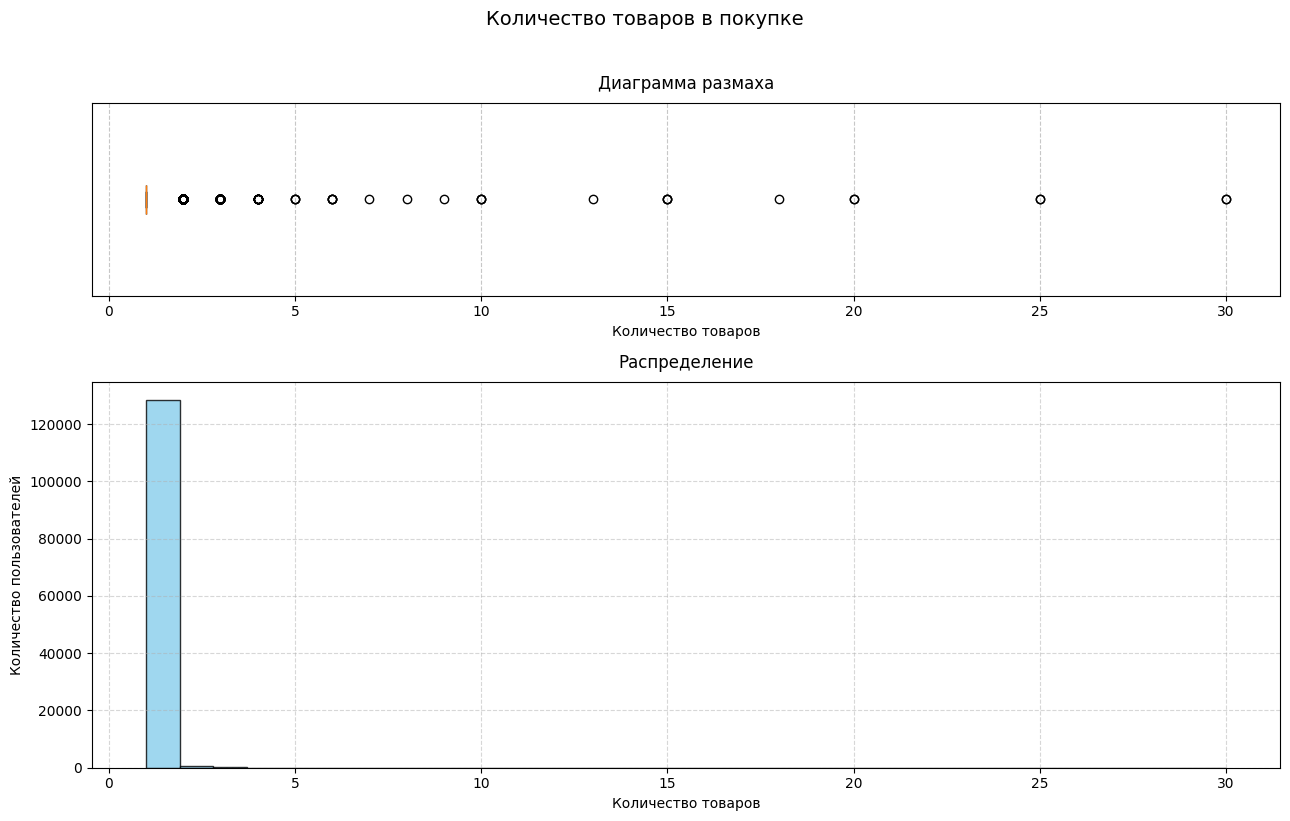

count    129188.000000
mean          1.009420
std           0.220332
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          30.000000
Name: quantity, dtype: float64

In [96]:
# выведем график распределения
plot_data_analysis(app_purchases['quantity'],
                   title = 'Количество товаров в покупке',
                   x_label = 'Количество товаров',
                   y_label = 'Количество пользователей',
                   plot_box = True,
                   discrete = False,
                   bins=32
                   )

**Промежуточный вывод**: подавляющее большинство товаров покупалось в количестве **1** шт.

#### Признак ```price```

**Комментарий**: рассмотрим подробнее признак ```price``` -- цена товара.

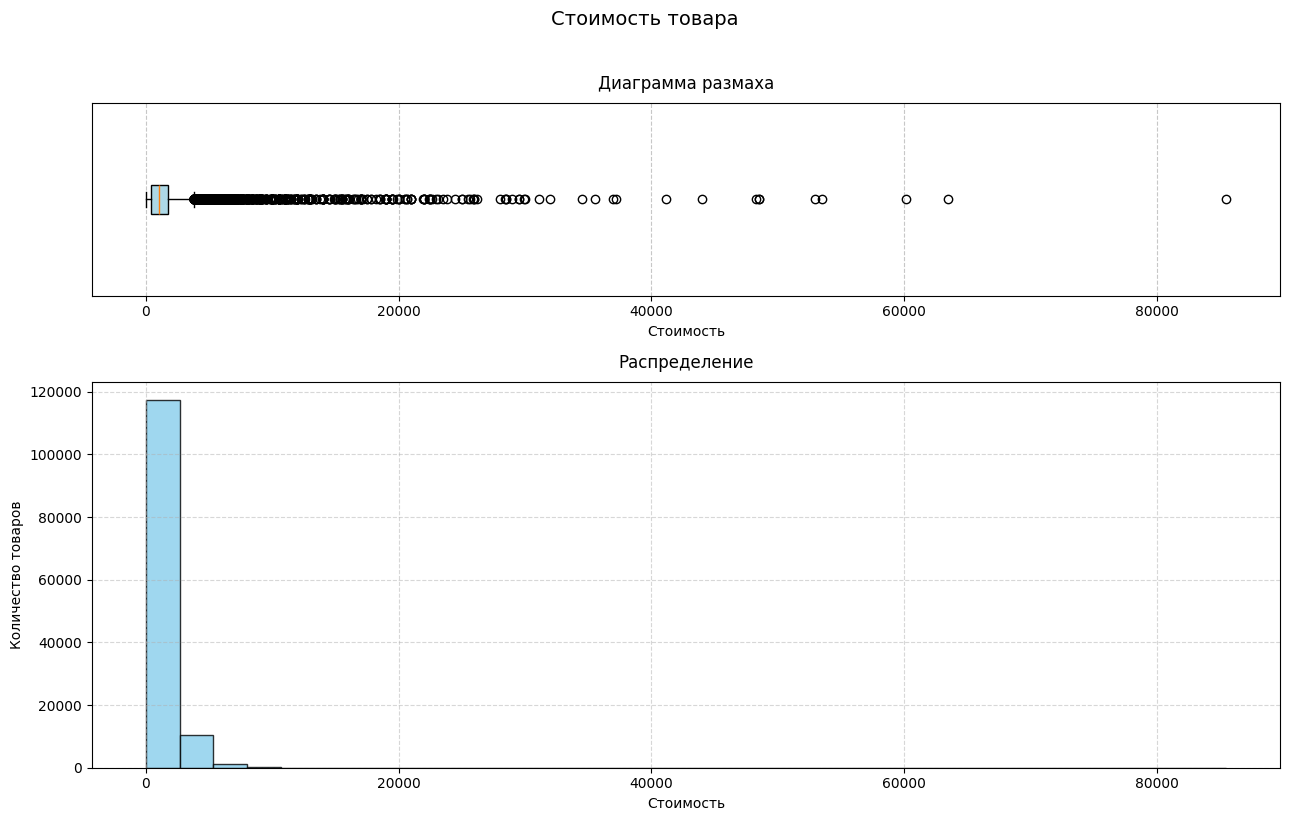

count    129188.000000
mean       1264.532766
std        1375.016339
min           1.000000
25%         399.000000
50%         999.000000
75%        1750.000000
max       85499.000000
Name: price, dtype: float64

In [97]:
# выведем график распределения
plot_data_analysis(app_purchases['price'],
                   title = 'Стоимость товара',
                   x_label = 'Стоимость',
                   y_label = 'Количество товаров',
                   plot_box = True,
                   discrete = False,
                   bins=32
                   )

**Промежуточный вывод**: в среднем стоимость товара составляет $\sim1300$, медианное значение **999**.

#### Признак ```category_ids```

**Комментарий**: рассмотрим подробнее признак ```category_ids``` -- идентификаторы категорий.

In [98]:
# посмотрим количество уникальных значений
print(f'Уникальных групп с категориями: {app_purchases['category_ids'].nunique()}')

Уникальных групп с категориями: 933


**Комментарий**: в данных группы с категориями представлены в виде строк. Предлагается следующая стратегия: выполнить парсинг строк, использовать несколько подходов для создания новых признаков:
- Найти маркеры -- категории, которые практически всегда присутствуют на верхнем уровне дерева;
- Разбить данные на категории по вложенным из ```category_ids```, убрав маркеры;
- Оставить последнюю категорию (конечную) из списка.

In [99]:
# функция для парсинга категорий
def parse_cats(x):
    if pd.isna(x) or x is None:
        return []
    if isinstance(x, list):
        return [str(i) for i in x if i is not None]
    try:
        parsed = literal_eval(str(x))
        return [str(i) for i in parsed if i is not None]
    except (ValueError, SyntaxError):
        return []

app_purchases['category_ids'] = app_purchases['category_ids'].apply(parse_cats)

# cчитаем, на каких позициях встречается каждая категория
position_counter = Counter()
for cats in app_purchases['category_ids']:
    for pos, cat in enumerate(cats):
        position_counter[(cat, pos)] += 1
        
# находим категории, которые чаще всего находятся на позиции 0 или 1
markers = []
total_counts = Counter([cat for cats in app_purchases['category_ids'] for cat in cats])

for (cat, pos), count in position_counter.items():
    if pos <= 1 and count / total_counts[cat] >= 0.95:
        if cat not in markers:
            markers.append(cat)

# выведем маркеры
print("Обнаруженные маркеры:", markers)

Обнаруженные маркеры: ['4', '28', '2', '18', '5562', '5631', '5630', '27', '5589', '5634', '31', '1822', '5837', '17', '5683', '29', '5536', '5597', '5633', '5599', '5632', '5558', '30', '1', '8', '5697', '22', '5963', '5959', '3', '14', '6060', '6058', '6059', '6057', '5', '10', '12']


In [100]:
# создаём признаки
print("Размерность исходного датасета:", app_purchases.shape)
# конечная категория
app_purchases['leaf_category'] = app_purchases['category_ids'].apply(lambda x: int(x[-1]) if len(x) > 0 else -1)

# маркеры
for marker in markers:
    app_purchases[f'is_marker_{marker}'] = app_purchases['category_ids'].apply(lambda x: int(marker in x[:2]))



Размерность исходного датасета: (129188, 6)


In [101]:
# выведем первые 5 записей обновленного датасета
app_purchases.drop(columns=['category_ids'], inplace=True)
print("Размерность обоновленного датасета:", app_purchases.shape)
app_purchases.head()

Размерность обоновленного датасета: (129188, 44)


client_id  quantity   price       date  \
0  1515915625468169594         1  1999.0 2022-05-16   
1  1515915625468169594         1  2499.0 2022-05-16   
2  1515915625471138230         1  6499.0 2022-05-16   
3  1515915625471138230         1  4999.0 2022-05-16   
4  1515915625471138230         1  4999.0 2022-05-16   

                               message_id  leaf_category  is_marker_4  \
0  1515915625468169594-4301-627b661e9736d            431            1   
1  1515915625468169594-4301-627b661e9736d            431            1   
2  1515915625471138230-4437-6282242f27843            431            1   
3  1515915625471138230-4437-6282242f27843            432            1   
4  1515915625471138230-4437-6282242f27843            413            1   

   is_marker_28  is_marker_2  is_marker_18  is_marker_5562  is_marker_5631  \
0             1            0             0               0               0   
1             1            0             0               0               0   
2             1            0             0               0               0   
3             1            0             0               0               0   
4             1            0             0               0               0   

   is_marker_5630  is_marker_27  is_marker_5589  is_marker_5634  is_marker_31  \
0               0             0               0               0             0   
1               0             0               0               0             0   
2               0             0               0               0             0   
3               0             0               0               0             0   
4               0             0               0               0             0   

   is_marker_1822  is_marker_5837  is_marker_17  is_marker_5683  is_marker_29  \
0               0               0             0               0             0   
1               0               0             0               0             0   
2               0               0             0               0             0   
3               0               0             0               0             0   
4               0               0             0               0             0   

   is_marker_5536  is_marker_5597  is_marker_5633  is_marker_5599  \
0               0               0               0               0   
1               0               0               0               0   
2               0               0               0               0   
3               0               0               0               0   
4               0               0               0               0   

   is_marker_5632  is_marker_5558  is_marker_30  is_marker_1  is_marker_8  \
0               0               0             0            0            0   
1               0               0             0            0            0   
2               0               0             0            0            0   
3               0               0             0            0            0   
4               0               0             0            0            0   

   is_marker_5697  is_marker_22  is_marker_5963  is_marker_5959  is_marker_3  \
0               0             0               0               0            0   
1               0             0               0               0            0   
2               0             0               0               0            0   
3               0             0               0               0            0   
4               0             0               0               0            0   

   is_marker_14  is_marker_6060  is_marker_6058  is_marker_6059  \
0             0               0               0               0   
1             0               0               0               0   
2             0               0               0               0   
3             0               0               0               0   
4             0               0               0               0   

   is_marker_6057  is_marker_5  is_mar

**Промежуточный вывод**: были сформированые новые признаки: маркеры, конечные категории, а также данные разбиты по категориям без маркеров.

#### Признак ```message_id```

**Комментарий**: рассмотрим подробнее признак ```message_id``` -- идентификатор сообщения из рассылки.

In [102]:
# посмотрим количество уникальных значений
print(f'Уникальных сообщений: {app_purchases['message_id'].nunique()}')

Уникальных сообщений: 50204


**Промежуточный вывод**: в данных содержится **50202** уникальных разосланных сообщений.

#### Промежуточный вывод

По результатам исследоватльского анализа данных:
- В данных содержится **49849** уникальных клиентов.
- Подавляющее большинство товаров покупалось в количестве **1** шт.
- В среднем стоимость товара составляет $\sim1300$, медианное значение **999**.
- Были сформированые новые признаки: маркеры, конечные категории, а также данные разбиты по категориям без маркеров.
- В данных содержится **50202** уникальных разосланных сообщений.

### Таблица ```app_messages```

**Комментарий**: исследуем таблицу ```app_messages``` -- история рекламных рассылок.

#### Признак ```bulk_campaign_id```

**Комментарий**: рассмотрим подробнее признак ```bulk_campaign_id``` -- идентификатор рассылки.

In [103]:
# посмотрим количество уникальных значений
print(f'Уникальных рекламных компаний/рассылок: {app_messages['bulk_campaign_id'].nunique()}')

Уникальных рекламных компаний/рассылок: 2709


**Промежуточный вывод**: в данных содержится **2709** уникальных ```id``` рекламных кампаний/рассылок.

#### Признак ```client_id```

**Комментарий**: рассмотрим подробнее признак ```client_id``` -- идентификатор клиента.

In [104]:
# посмотрим количество уникальных значений
print(f'Уникальных клиентов: {app_messages['client_id'].nunique()}')

Уникальных клиентов: 53329


**Промежуточный вывод**: в данных содержится **53329** уникальных клиентов.

#### Признак ```message_id```

**Комментарий**: рассмотрим подробнее признак ```message_id``` -- идентификатор сообщения.

In [105]:
# посмотрим количество уникальных значений
print(f'Уникальных сообщений: {app_messages['message_id'].nunique()}')

Уникальных сообщений: 9061667


**Промежуточный вывод**: в данных содержится $\sim$**9** млн. уникальных разосланных сообщений.

#### Признак ```event```

**Комментарий**: рассмотрим подробнее признак ```event``` -- действие с сообщением (отправлено, открыто, покупка...).

In [106]:
# посмотрим уникальные значения в столбце event
app_messages['event'].unique()

array(['open', 'click', 'purchase', 'send', 'unsubscribe', 'hbq_spam',
       'hard_bounce', 'subscribe', 'soft_bounce', 'complain', 'close'],
      dtype=object)

**Комментарий**: видим следующие уникальные значения признака ```event```:
- `open` - открытие письма/сообщения;
- `click` - клик по ссылке в письме;
- `purchase` - покупка (триггерится из рассылки);
- `send` - отправка сообщения пользователю;
- `unsubscribe` - отписка от рассылки;
- `hbq_spam` - жалоба на спам (спам-репорт);
- `hard_bounce` - постоянная ошибка доставки (например, несуществующий e-mail);
- `subscribe` - подписка на рассылку;
- `soft_bounce` - временная ошибка доставки (переполненный ящик и т.д.);
- `complain` - жалоба;
- `close` - закрытие письма/сообщения.

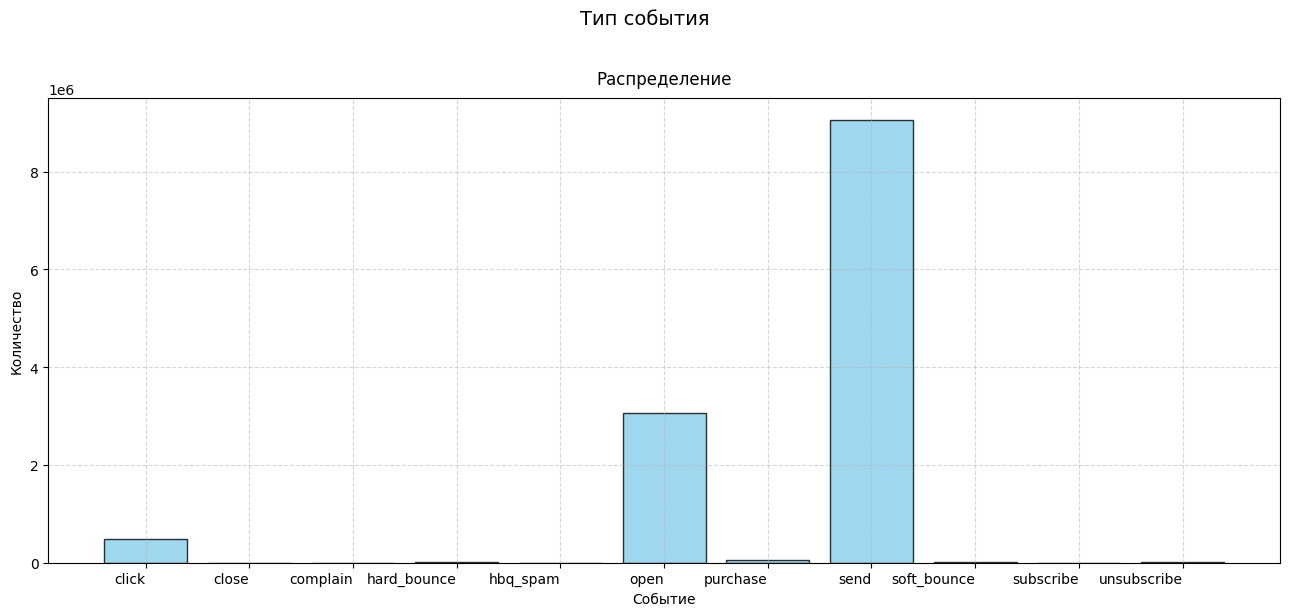

count     12691188
unique          11
top           send
freq       9058174
Name: event, dtype: object

In [107]:
# выведем график распределения
plot_data_analysis(app_messages['event'],
                   title = 'Тип события',
                   x_label = 'Событие',
                   y_label = 'Количество',
                   plot_bar = True,
                   plot_box = False,
                   discrete = True
                   )

In [108]:
# посмотрим количество значений
app_messages['event'].value_counts()

event
send           9058174
open           3052481
click           483326
purchase         62593
hard_bounce      19763
soft_bounce      10582
unsubscribe       2833
hbq_spam           823
complain           527
subscribe           85
close                1
Name: count, dtype: int64

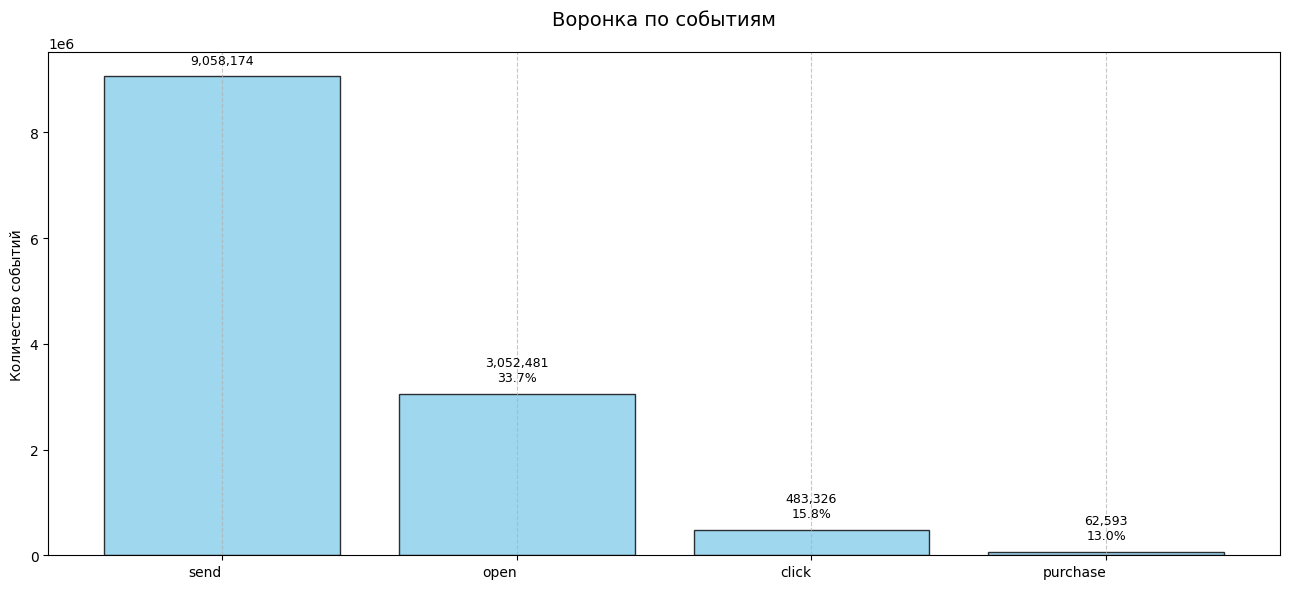

Статистика воронки:
send                       9,058,174: (100.0%)
open                       3,052,481: (33.7% | 33.7%)
click                        483,326: (15.8% | 5.3%)
purchase                      62,593: (13.0% | 0.7%)
Общая конверсия: 0.69%
Потери: 8,995,581 событий


In [109]:
# построим маркетинговую воронку по событиям
plot_funnel(
    app_messages,
    'event',
    ['send', 'open', 'click', 'purchase'],
    title = 'Воронка по событиям',
    orientation = 'horizontal'
)

**Промежуточный вывод**: на основе имеющейся информации о событиях, можно оценить общую конверсию -- $\sim0.71\%$. При этом из общего количества сообщений $34.1\%$ были открыты, $16.1%$ затем прокликаны и $13\%$ пользователей совершили покупку.

#### Признак ```channel```

**Комментарий**: рассмотрим подробнее признак ```channel``` -- канал рассылки.

In [110]:
# посмотрим уникальные значения в столбце channel
app_messages['channel'].unique()

array(['email', 'mobile_push'], dtype=object)

**Комментарий**: видим два уникальных типа рассылки в ```channel```:
- `email` - рассылка по электронной почте;
- `mobile_push` - рассылка через push-уведомления. 

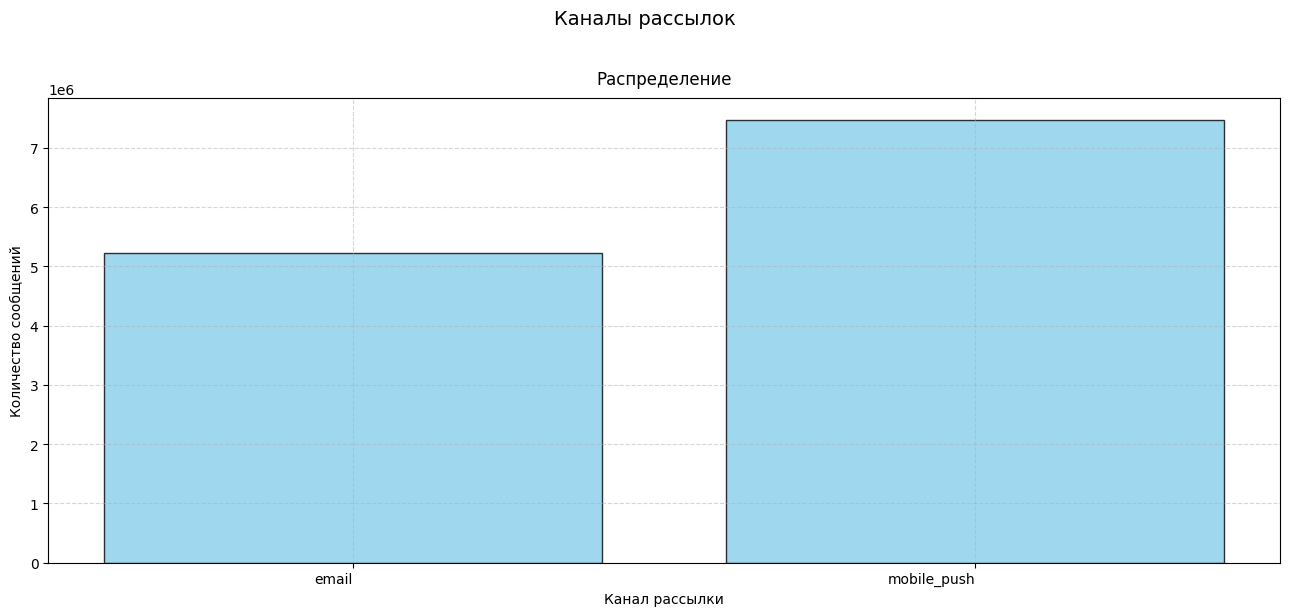

count        12691188
unique              2
top       mobile_push
freq          7470472
Name: channel, dtype: object

In [111]:
# выведем график распределения
plot_data_analysis(app_messages['channel'],
                   title = 'Каналы рассылок',
                   x_label = 'Канал рассылки',
                   y_label = 'Количество сообщений',
                   plot_bar = True,
                   plot_box = False,
                   discrete = True
                   )

In [112]:
# посмотрим количество значений
app_messages['channel'].value_counts()

channel
mobile_push    7470472
email          5220716
Name: count, dtype: int64

**Промежуточный вывод**: рассылки чаще осуществлялись через ```push``` уведомления. 

#### Промежуточный вывод

По результатам исследовательского анализа данных:
- В данных содержится **2709** уникальных ```id``` рекламных кампаний/рассылок;
- В данных содержится **53329** уникальных клиентов;
- В данных содержится $\sim$**9** млн. уникальных разосланных сообщений;
- На основе имеющейся информации о событиях, можно оценить общую конверсию -- $\sim0.71\%$. При этом из общего количества сообщений $34.1\%$ были открыты, $16.1%$ затем прокликаны и $13\%$ пользователей совершили покупку;
- Рассылки чаще осуществлялись через ```push``` уведомления;
- В данных содержится **53329** уникальных клиентов.

### Таблица ```app_target```

**Комментарий**: исследуем таблицу ```app_target``` -- целевой признак -- совершит ли клиент покупку в течение следующих 90 дней.

#### Признак ```client_id```

**Комментарий**: рассмотрим подробнее признак ```client_id``` -- идентификатор клиента.

In [113]:
# посмотрим количество уникальных значений
print(f'Уникальных клиентов: {app_target['client_id'].nunique()}')

Уникальных клиентов: 49849


**Промежуточный вывод**: в данных содержится **49849** уникальных клиентов (количество совпадает с ```app_purchase```).

#### Признак ```target```

**Комментарий**: рассмотрим подробнее признак ```target``` -- целевой признак.

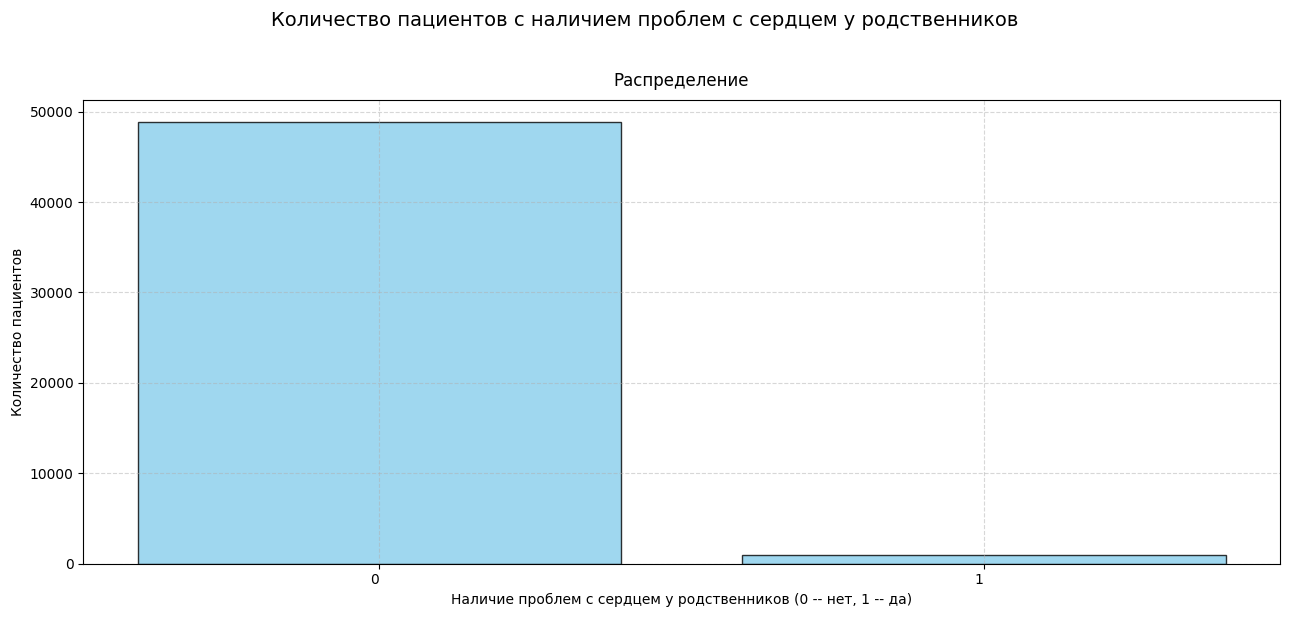

count    49849.000000
mean         0.019278
std          0.137503
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: target, dtype: float64

In [114]:
# выведем график распределения
plot_data_analysis(app_target['target'],
                   title = 'Количество пациентов с наличием проблем с сердцем у родственников',
                   x_label = 'Наличие проблем с сердцем у родственников (0 -- нет, 1 -- да)',
                   y_label = 'Количество пациентов',
                   plot_bar = True,
                   plot_box = False,
                   discrete = True
                   )

In [115]:
# посмотрим количество значений
app_target['target'].value_counts()

target
0    48888
1      961
Name: count, dtype: int64

**Промежуточный вывод**: в целевом признаке наблюдается сильнейший дисбаланс, необходимо учитывать при обучении моделей.

#### Промежуточный вывод

По результатам исследовательского анализа данных:
- В данных содержится **49849** уникальных клиентов (количество совпадает с ```app_purchase```).
- В целевом признаке наблюдается сильнейший дисбаланс, необходимо учитывать при обучении моделей.

### Таблица ```fc_daily```

**Комментарий**: исследуем таблицу ```fc_daily``` -- агрегация общей базы рассылок по дням и типам событий.

#### Признак ```bulk_campaign_id```

**Комментарий**: исследуем подробнее признак ```bulk_campaign_id``` -- идентификатор рекламной кампании.

In [116]:
# посмотрим количество уникальных значений
print(f'Уникальных рассылок/кампаний: {fc_daily['bulk_campaign_id'].nunique()}')

Уникальных рассылок/кампаний: 3181


**Промежуточный вывод**: в данных содержится **3181** уникальных рекламных кампаний.

In [117]:
fc_daily.sort_values(['date'], inplace=True)

In [118]:
fc_daily.head()

date  bulk_campaign_id  count_click  count_complain  \
0  2022-05-19               563            0               0   
96 2022-05-19              2947            0               0   
97 2022-05-19              3001            0               0   
98 2022-05-19              3036            0               0   
99 2022-05-19              3043            1               0   

    count_hard_bounce  count_open  count_purchase  count_send  \
0                   0           4               0           0   
96                  0          37               0           0   
97                  0          41               0           0   
98                  0           5               0           0   
99                  0          55               0           0   

    count_soft_bounce  count_subscribe  count_unsubscribe  nunique_click  \
0                   0                0                  0              0   
96                  0                0                  1              0   
97                  0                0                  1              0   
98                  0                0                  0              0   
99                  0                0                  0              1   

    nunique_complain  nunique_hard_bounce  nunique_open  nunique_purchase  \
0                  0                    0             4                 0   
96                 0                    0            36                 0   
97                 0                    0            40                 0   
98                 0                    0             5                 0   
99                 0                    0            51                 0   

    nunique_send  nunique_soft_bounce  nunique_subscribe  nunique_unsubscribe  \
0              0                    0                  0                    0   
96             0                    0                  0                    1   
97             0                    0                  0                    1   
98             0                    0                  0                    0   
99             0                    0                  0                    0   

    count_hbq_spam  nunique_hbq_spam  count_close  nunique_close  
0                0                 0            0              0  
96               0                 0            0              0  
97               0                 0            0              0  
98               0                 0            0              0  
99               0                 0            0              0

### Таблица ```fc_daily_channel```

**Комментарий**: исследуем таблицу ```fc_daily_channel``` -- агрегация по дням с учетом событий и каналов рассылки.

In [119]:
fc_daily_channel.sort_values(['date'], inplace=True)

In [120]:
fc_daily_channel.head()

date  bulk_campaign_id  count_click_email  count_click_mobile_push  \
0  2022-05-19               563                  0                        0   
96 2022-05-19              2947                  0                        0   
97 2022-05-19              3001                  0                        0   
98 2022-05-19              3036                  0                        0   
99 2022-05-19              3043                  1                        0   

    count_open_email  count_open_mobile_push  count_purchase_email  \
0                  4                       0                     0   
96                37                       0                     0   
97                41                       0                     0   
98                 5                       0                     0   
99                55                       0                     0   

    count_purchase_mobile_push  count_soft_bounce_email  \
0                            0                        0   
96                           0                        0   
97                           0                        0   
98                           0                        0   
99                           0                        0   

    count_subscribe_email  count_unsubscribe_email  nunique_click_email  \
0                       0                        0                    0   
96                      0                        1                    0   
97                      0                        1                    0   
98                      0                        0                    0   
99                      0                        0                    1   

    nunique_click_mobile_push  nunique_open_email  nunique_open_mobile_push  \
0                           0                   4                         0   
96                          0                  36                         0   
97                          0                  40                         0   
98                          0                   5                         0   
99                          0                  51                         0   

    nunique_purchase_email  nunique_purchase_mobile_push  \
0                        0                             0   
96                       0                             0   
97                       0                             0   
98                       0                             0   
99                       0                             0   

    nunique_soft_bounce_email  nunique_subscribe_email  \
0                           0                        0   
96                          0                        0   
97                          0                        0   
98                          0                        0   
99                          0                        0   

    nunique_unsubscribe_email  count_hard_bounce_mobile_push  \
0                           0                              0   
96                          1                              0   
97                          1                              0   
98                          0                              0   
99                          0                              0   

    count_send_mobile_push  nunique_hard_bounce_mobile_push  \
0                        0                                0   
96                       0                                0   
97                       0                                0   
98                       0                                0   
99                       0                                0   

    nunique_send_mobile_push  count_hard_bounce_email  count_hbq_spam_email  \
0                          0                        0                     0   
96                         0                        0                     0   
97                         0                        0                     0   
98                         0              

### Объединение данных и создание признаков

In [121]:
#максимальная дата из покупок
last_date = app_purchases['date'].max()
print(last_date)

2024-02-16 00:00:00


In [ ]:
app_purchases['revenue'] = app_purchases['quantity'] * app_purchases['price']

purchase_features = app_purchases.groupby('client_id').agg(
    purchase_cnt=('date', 'count'),
    total_revenue=('revenue', 'sum'),
    avg_order_value=('revenue', 'mean'),
    avg_price=('price', 'mean'),
    total_quantity=('quantity', 'sum'),
    first_purchase_date=('date', 'min'),
    last_purchase_date=('date', 'max'),
).reset_index()

purchase_features['recency_days'] = (last_date - purchase_features['last_purchase_date']).dt.days
purchase_features['lifespan_days'] = (purchase_features['last_purchase_date'] - purchase_features['first_purchase_date']).dt.days + 1
purchase_features['purchase_freq_per_month'] = purchase_features['purchase_cnt'] / (purchase_features['lifespan_days'] / 30.0)

In [123]:
purchase_features.head()

client_id  purchase_cnt  total_revenue  avg_order_value  \
0  1515915625468060902             5         4795.0       959.000000   
1  1515915625468061003             6        14135.0      2355.833333   
2  1515915625468061099             1          299.0       299.000000   
3  1515915625468061100             1         1049.0      1049.000000   
4  1515915625468061170             8        14102.0      1762.750000   

     avg_price  total_quantity  purchase_from_campaign first_purchase_date  \
0   959.000000               5                       5          2022-05-27   
1  2355.833333               6                       6          2023-01-04   
2   299.000000               1                       1          2022-05-17   
3  1049.000000               1                       1          2024-02-10   
4  1762.750000               8                       8          2023-03-26   

  last_purchase_date  recency_days  days_since_first_purchase  lifespan_days  \
0         2022-05-27           630                        630              1   
1         2023-01-04           408                        408              1   
2         2022-05-17           640                        640              1   
3         2024-02-10             6                          6              1   
4         2023-06-17           244                        327             84   

   purchase_freq_per_month  
0               150.000000  
1               180.000000  
2                30.000000  
3                30.000000  
4                 2.857143

In [155]:
messages_enr = app_messages.merge(
    fc_daily.add_prefix('camp_'), 
    left_on=['date', 'bulk_campaign_id'],
    right_on=['camp_date', 'camp_bulk_campaign_id'],
    how='left'
)

messages_enr = messages_enr.merge(
    fc_daily_channel.add_prefix('camp_ch_'), 
    left_on=['date', 'bulk_campaign_id'],
    right_on=['camp_ch_date', 'camp_ch_bulk_campaign_id'],
    how='left'
)


base_agg = {
    'message_id': 'count',
    'bulk_campaign_id': 'nunique',
    'channel': 'nunique',
    'date': ['max', 'min'],
}

camp_cols = [col for col in messages_enr.columns 
             if col.startswith('camp_') and col not in ['camp_date', 'camp_bulk_campaign_id', 
                                                        'camp_ch_date', 'camp_ch_bulk_campaign_id']]

camp_agg = {col: 'mean' for col in camp_cols}


full_agg = {**base_agg, **camp_agg}
msg_feat = messages_enr.groupby('client_id').agg(full_agg).reset_index()

# Правильный flatten мультииндекса (теперь будет date_max, date_min и т.д.)
msg_feat.columns = ['_'.join(col).strip('_') for col in msg_feat.columns.values]

# Переименовываем базовые колонки
msg_feat = msg_feat.rename(columns={
    'message_id_count': 'total_messages',
    'bulk_campaign_id_nunique': 'unique_campaigns',
    'channel_nunique': 'unique_channels',
    'date_max': 'last_msg_date',
    'date_min': 'first_msg_date',
})

# Пивоты событий и каналов
event_pivot = pd.crosstab(messages_enr['client_id'], messages_enr['event']).add_prefix('event_').reset_index()
channel_pivot = pd.crosstab(messages_enr['client_id'], messages_enr['channel']).add_prefix('channel_').reset_index()

# Правильные конверсии (особенно open_rate = opens / sends)
conv = messages_enr.groupby('client_id').apply(lambda g: pd.Series({
    'open_rate': (g['event'] == 'open').sum() / (g['event'] == 'send').sum() if (g['event'] == 'send').sum() > 0 else 0,
    'click_rate': (g['event'] == 'click').sum() / (g['event'] == 'open').sum() if (g['event'] == 'open').sum() > 0 else 0,
    'ctr': (g['event'] == 'click').sum() / (g['event'] == 'send').sum() if (g['event'] == 'send').sum() > 0 else 0,
    'purchase_from_click_rate': (g['event'] == 'purchase').sum() / (g['event'] == 'click').sum() if (g['event'] == 'click').sum() > 0 else 0,
    'unsubscribe_rate': (g['event'] == 'unsubscribe').sum() / (g['event'] == 'send').sum() if (g['event'] == 'send').sum() > 0 else 0,
})).reset_index()

# Собираем всё
msg_feat = msg_feat.merge(event_pivot, on='client_id', how='left') \
                   .merge(channel_pivot, on='client_id', how='left') \
                   .merge(conv, on='client_id', how='left')

# Правильный recency (snapshot_date определён выше в твоей тетрадке)
msg_feat['msg_recency_days'] = (last_date - msg_feat['last_msg_date']).dt.days

print(f"msg_feat готов: {msg_feat.shape[0]} клиентов, {msg_feat.shape[1]} признаков")

msg_feat готов: 53329 клиентов, 81 признаков


In [156]:
df_master = app_target[['client_id', 'target']].copy()

df_master = df_master.merge(purchase_features, on='client_id', how='left')
df_master = df_master.merge(msg_feat, on='client_id', how='left')

zero_cols = [
    'purchase_cnt', 'total_revenue', 'avg_order_value', 'avg_price', 'avg_quantity', 'total_quantity',
    'purchase_from_campaign_cnt', 'purchase_from_campaign_share', 'purchase_freq_per_month',
    'total_messages', 'unique_campaigns', 'unique_channels',
    'open_rate', 'click_rate', 'ctr', 'purchase_from_click_rate', 'unsubscribe_rate'
]

recency_cols = ['recency_days', 'msg_recency_days', 'days_since_first']

# Заполняем ТОЛЬКО если колонка реально существует
for col in zero_cols:
    if col in df_master.columns:
        df_master[col] = df_master[col].fillna(0)

for col in recency_cols:
    if col in df_master.columns:
        df_master[col] = df_master[col].fillna(9999)

# Все кампанийные колонки → 0
camp_cols = [c for c in df_master.columns if c.startswith('camp_')]
df_master[camp_cols] = df_master[camp_cols].fillna(0)

def safe_flag(col_name, default=0):
    if col_name in df_master.columns:
        return (df_master[col_name] > 0).astype(int)
    else:
        return pd.Series([default] * len(df_master), index=df_master.index)

df_master['has_purchases'] = (df_master['purchase_cnt'].fillna(0) > 0).astype(int)
df_master['has_messages']   = (df_master['total_messages'].fillna(0) > 0).astype(int)

df_master['ever_opened']      = safe_flag('event_open')
df_master['ever_clicked']     = safe_flag('event_click')
df_master['ever_unsubscribed']= safe_flag('event_unsubscribe')
df_master['ever_purchased_from_campaign'] = safe_flag('purchase_from_campaign_cnt')

# Если хочешь бинарный флаг "покупал из рассылки" даже если cnt не создался
if 'purchase_from_campaign_share' in df_master.columns:
    df_master['ever_purchased_from_campaign'] = (df_master['purchase_from_campaign_share'] > 0).astype(int)

print(f"Размерность итогового набора данных: {df_master.shape}")

Размерность итогового набора данных: (49849, 101)


In [157]:
df_master.head()

client_id  target  purchase_cnt  total_revenue  avg_order_value  \
0  1515915625468060902       0          10.0         9590.0       959.000000   
1  1515915625468061003       1          12.0        28270.0      2355.833333   
2  1515915625468061099       0           2.0          598.0       299.000000   
3  1515915625468061100       0           2.0         2098.0      1049.000000   
4  1515915625468061170       0          14.0        28190.0      2013.571429   

     avg_price  avg_quantity  total_quantity  purchase_from_campaign  \
0   959.000000           1.0            10.0                    10.0   
1  2355.833333           1.0            12.0                    12.0   
2   299.000000           1.0             2.0                     2.0   
3  1049.000000           1.0             2.0                     2.0   
4  2013.571429           1.0            14.0                    14.0   

  first_purchase_date last_purchase_date  recency_days  \
0          2022-05-27         2022-05-27         630.0   
1          2023-01-04         2023-01-04         408.0   
2          2022-05-17         2022-05-17         640.0   
3          2024-02-10         2024-02-10           6.0   
4          2023-03-26         2023-06-17         244.0   

   days_since_first_purchase  lifespan_days  purchase_freq_per_month  \
0                      630.0            1.0                    300.0   
1                      408.0            1.0                    360.0   
2                      640.0            1.0                     60.0   
3                        6.0            1.0                     60.0   
4                      327.0           84.0                      5.0   

   total_messages  unique_campaigns  unique_channels last_msg_date  \
0           177.0             127.0              1.0    2024-01-19   
1           165.0             154.0              1.0    2024-02-13   
2           276.0             215.0              2.0    2024-02-13   
3           428.0             265.0              1.0    2024-02-15   
4           293.0             240.0              2.0    2024-02-15   

  first_msg_date  camp_count_click_mean  camp_count_complain_mean  \
0     2022-05-19           11992.271186                 21.214689   
1     2022-05-20           13197.436364                 19.896970   
2     2022-05-19           10029.083333                 15.173913   
3     2022-05-19            4394.137850                  0.000000   
4     2022-05-25           10282.238908                 16.962457   

   camp_count_hard_bounce_mean  camp_count_open_mean  \
0                  3533.214689          99910.225989   
1                  4786.630303         102618.163636   
2                  5312.731884         194895.706522   
3                 10937.144860         573703.595794   
4                  5415.218430         479494.897611   

   camp_count_purchase_mean  camp_count_send_mean  \
0                 84.322034          1.795374e+06   
1                 88.660606          2.049172e+06   
2                 66.460145          1.594340e+06   
3                 17.238318          1.207701e+06   
4                 56.375427          1.954062e+06   

   camp_count_soft_bounce_mean  camp_count_subscribe_mean  \
0                 10097.107345                  29.259887   
1                 10581.060606                  34.187879   
2                  6809.036232                  20.322464   
3                   336.126168                   0.000000   
4                  6177.242321                  16.566553   

   camp_count_unsubscribe_mean  camp_nunique_click_mean  \
0                  1055.502825              9162.429379   
1                  1241.218182              9994.763636   
2                   768.141304              7627.974638   
3                     0.000000              3614.242991   
4                   584.286689              7779.989761   

   camp_nunique_complain_mean  camp_nunique_hard_bounce_mean  \
0                   21.163842          

## <u>Корреляционный анализ</u>

In [158]:
df_master.drop(columns=['client_id'], inplace=True)

In [159]:
# сформируем список столбцов с непрерывными признаками
interval_columns = df_master.select_dtypes(include='number').columns.tolist()
interval_columns = [c for c in interval_columns if c not in ['client_id', 'target']]

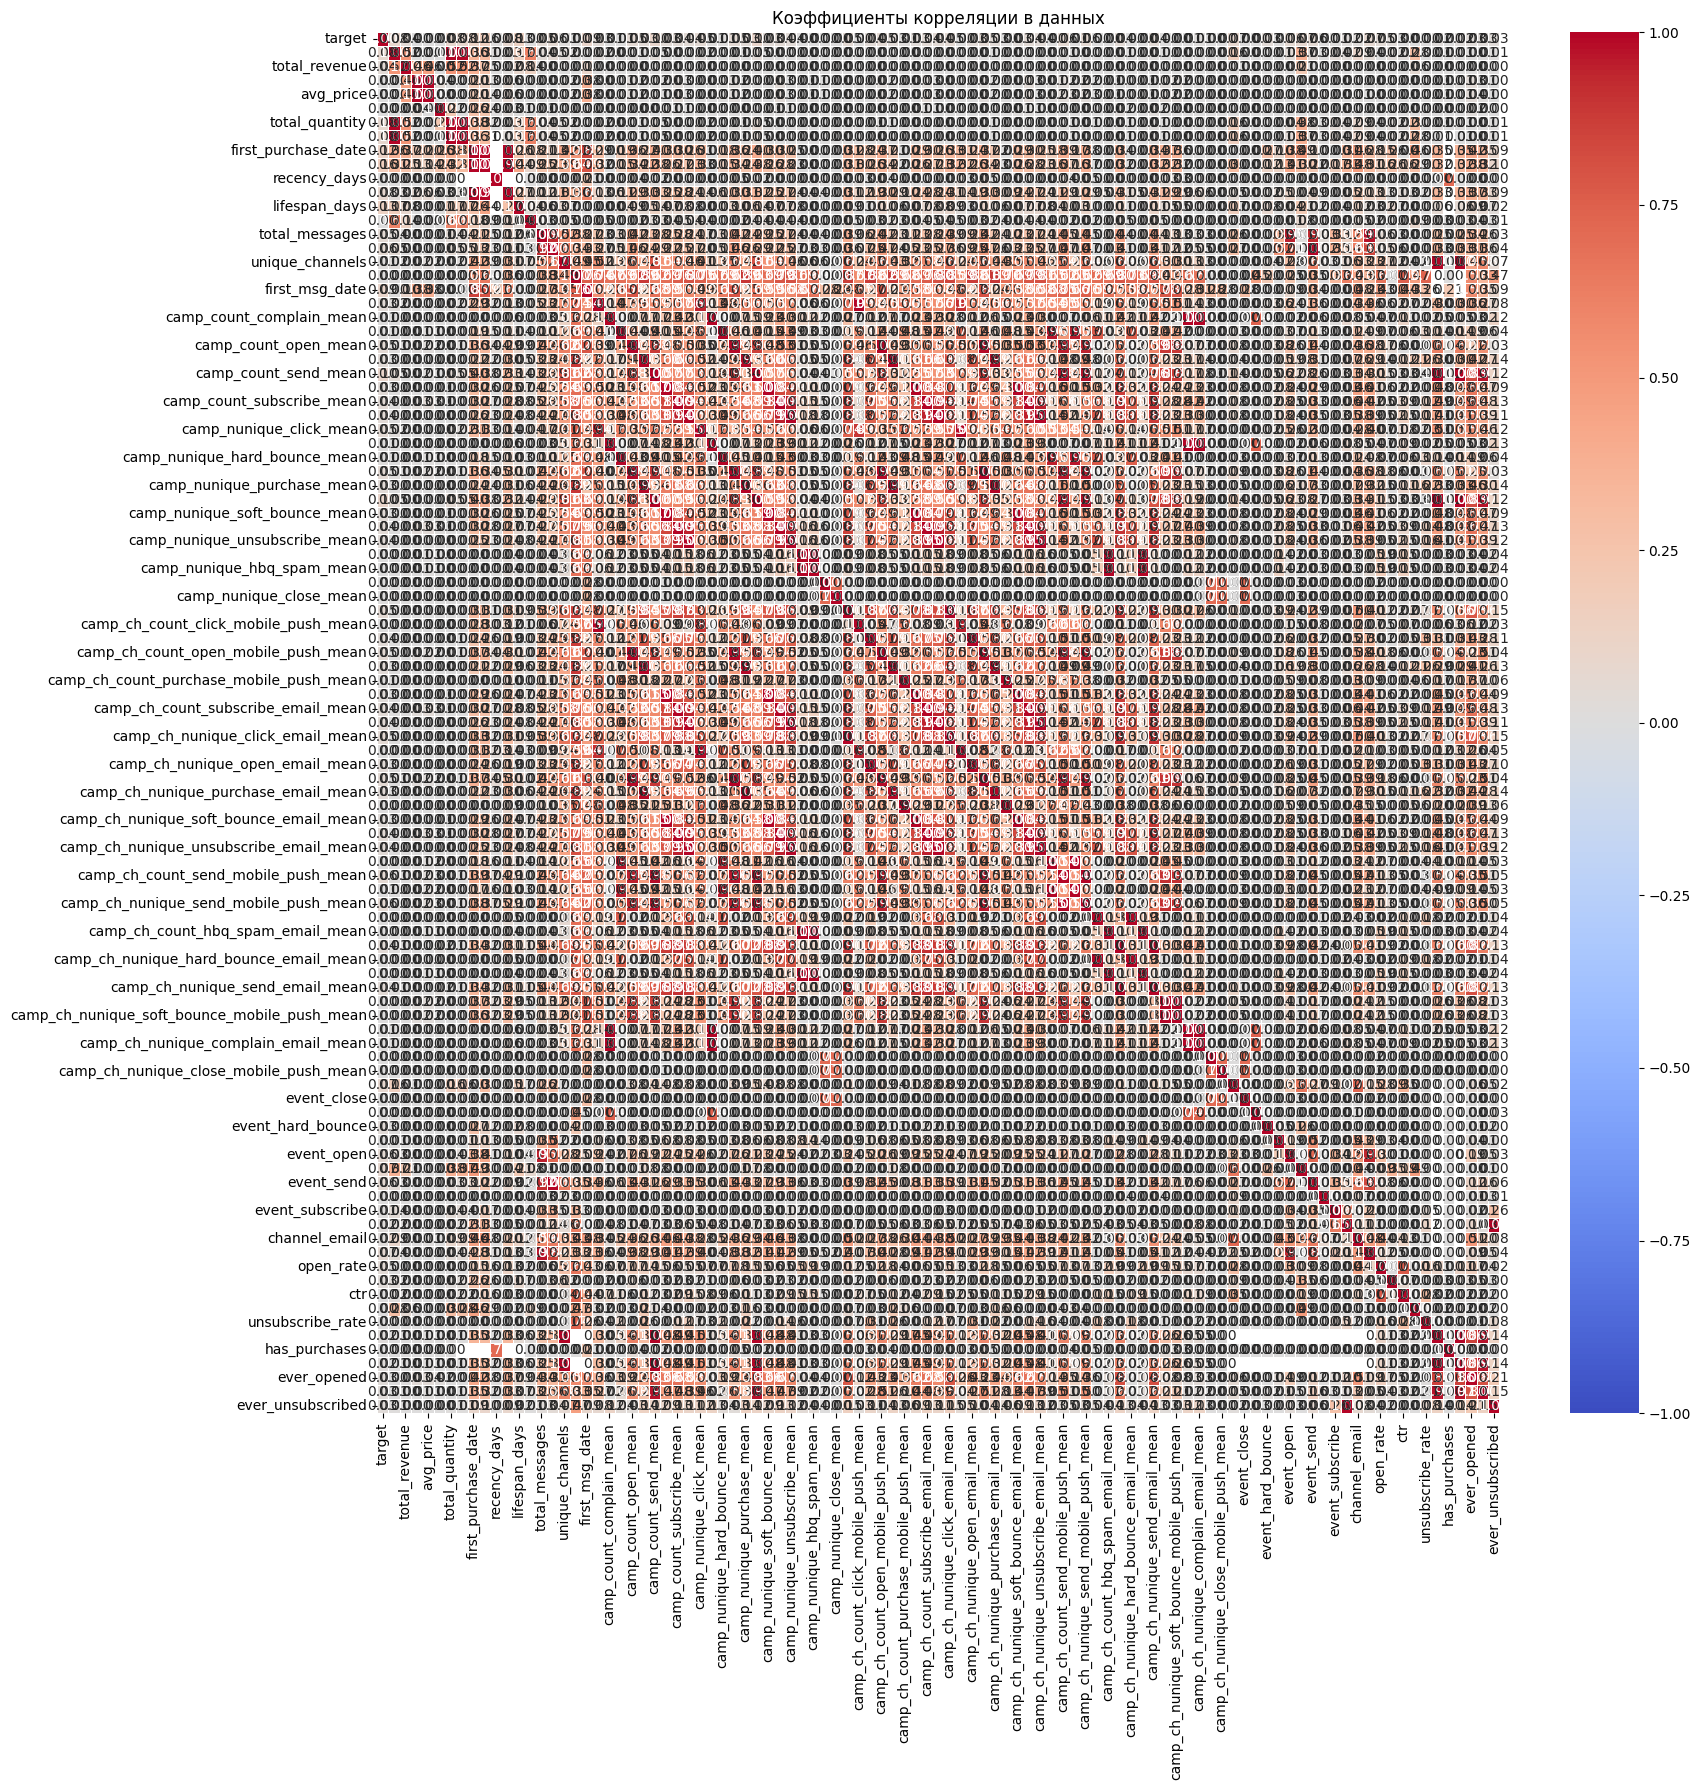

target  purchase_cnt  \
target                                        1.000000      0.083698   
purchase_cnt                                  0.083698      1.000000   
total_revenue                                 0.044763      0.519815   
avg_order_value                               0.000000      0.000000   
avg_price                                     0.000000      0.000000   
avg_quantity                                  0.000000      0.000000   
total_quantity                                0.084051      0.999257   
purchase_from_campaign                        0.084178      0.999993   
first_purchase_date                           0.123193      0.361518   
last_purchase_date                            0.163989      0.308049   
recency_days                                  0.000000      0.000000   
days_since_first_purchase                     0.075873      0.028924   
lifespan_days                                 0.133633      0.165205   
purchase_freq_per_month                       0.000000      0.608330   
total_messages                                0.051475      0.036711   
unique_campaigns                              0.055566      0.048645   
unique_channels                               0.008883      0.016170   
last_msg_date                                 0.000000      0.000000   
first_msg_date                                0.094728      0.000000   
camp_count_click_mean                         0.034415      0.016236   
camp_count_complain_mean                      0.007653      0.000000   
camp_count_hard_bounce_mean                   0.005934      0.000000   
camp_count_open_mean                          0.049235      0.011158   
camp_count_purchase_mean                      0.033056      0.000000   
camp_count_send_mean                          0.100652      0.045725   
camp_count_soft_bounce_mean                   0.032049      0.000000   
camp_count_subscribe_mean                     0.043824      0.000000   
camp_count_unsubscribe_mean                   0.039090      0.000000   
camp_nunique_click_mean                       0.049123      0.020713   
camp_nunique_complain_mean                    0.008513      0.000000   
camp_nunique_hard_bounce_mean                 0.008642      0.000000   
camp_nunique_open_mean                        0.051500      0.012082   
camp_nunique_purchase_mean                    0.033467      0.000000   
camp_nunique_send_mean                        0.101431      0.046690   
camp_nunique_soft_bounce_mean                 0.031849      0.000000   
camp_nunique_subscribe_mean                   0.043598      0.000000   
camp_nunique_unsubscribe_mean                 0.038531      0.000000   
camp_count_hbq_spam_mean                      0.000000      0.000000   
camp_nunique_hbq_spam_mean                    0.000000      0.000000   
camp_count_close_mean                         0.000000      0.000000   
camp_nunique_close_mean                       0.000000      0.000000   
camp_ch_count_click_email_mean                0.048361      0.004228   
camp_ch_count_click_mobile_push_mean          0.000000      0.000000   
camp_ch_count_open_email_mean                 0.035129      0.004485   
camp_ch_count_open_mobile_push_mean           0.050854      0.003700   
camp_ch_count_purchase_email_mean             0.032634      0.000000   
camp_ch_count_purchase_mobile_push_mean       0.010426      0.000000   
camp_ch_count_soft_bounce_email_mean          0.030866      0.000000   
camp_ch_count_subscribe_email_mean            0.043824      0.000000   
camp_ch_count_unsubscribe_email_mean          0.039090      0.000000   
camp_ch_nunique_click_email_mean              0.049103      0.004413   
camp_ch_nunique_click_mobile_push_mean        0.000000      0.000000   
camp_ch_nunique_open_email_mean               0.034980      0.000000   
camp_ch_nunique_open_mobile_push_mean         0.050722      0.005024   
camp_ch_nunique_purchase_email_mean           0.033850      0.000000   
camp_ch_nunique_

In [160]:
# рассчитаем корреляцию и построим матрицу коэффициентов корреляции и тепловую карту
corr_matrix = plot_corr_heatmap(df_master,
                                title = 'Коэффициенты корреляции в данных',
                                columns = interval_columns)
display(corr_matrix)

In [161]:
# проведем беглый анализ корреляционной матрицы
corr_res = corr_analysis(corr_matrix, target_feature='target', min_abs_corr=1e-8)

In [162]:
# выведем результаты анализа корреляционной матрицы
display(corr_res)

Признак Корреляция    Сила связи  \
0                             last_purchase_date      0.164        Слабая   
1                                  lifespan_days      0.134        Слабая   
2                            first_purchase_date      0.123        Слабая   
3                         camp_nunique_send_mean      0.101        Слабая   
4                           camp_count_send_mean      0.101        Слабая   
5                                 first_msg_date      0.095  Очень слабая   
6                         purchase_from_campaign      0.084  Очень слабая   
7                                 total_quantity      0.084  Очень слабая   
8                                   purchase_cnt      0.084  Очень слабая   
9                      days_since_first_purchase      0.076  Очень слабая   
10                                   event_click      0.075  Очень слабая   
11                                event_purchase      0.074  Очень слабая   
12                           channel_mobile_push      0.067  Очень слабая   
13                                    event_open      0.060  Очень слабая   
14           camp_ch_count_send_mobile_push_mean      0.059  Очень слабая   
15                                    event_send      0.058  Очень слабая   
16         camp_ch_nunique_send_mobile_push_mean      0.057  Очень слабая   
17                              unique_campaigns      0.056  Очень слабая   
18                        camp_nunique_open_mean      0.051  Очень слабая   
19                                total_messages      0.051  Очень слабая   
20           camp_ch_count_open_mobile_push_mean      0.051  Очень слабая   
21         camp_ch_nunique_open_mobile_push_mean      0.051  Очень слабая   
22                          camp_count_open_mean      0.049  Очень слабая   
23                       camp_nunique_click_mean      0.049  Очень слабая   
24              camp_ch_nunique_click_email_mean      0.049  Очень слабая   
25                camp_ch_count_click_email_mean      0.048  Очень слабая   
26                                     open_rate      0.046  Очень слабая   
27                                 total_revenue      0.045  Очень слабая   
28                     camp_count_subscribe_mean      0.044  Очень слабая   
29            camp_ch_count_subscribe_email_mean      0.044  Очень слабая   
30                   camp_nunique_subscribe_mean      0.044  Очень слабая   
31          camp_ch_nunique_subscribe_email_mean      0.044  Очень слабая   
32                 camp_ch_count_send_email_mean      0.044  Очень слабая   
33               camp_ch_nunique_send_email_mean      0.043  Очень слабая   
34                   camp_count_unsubscribe_mean      0.039  Очень слабая   
35          camp_ch_count_unsubscribe_email_mean      0.039  Очень слабая   
36                 camp_nunique_unsubscribe_mean      0.039  Очень слабая   
37        camp_ch_nunique_unsubscribe_email_mean      0.039  Очень слабая   
38                 camp_ch_count_open_email_mean      0.035  Очень слабая   
39               camp_ch_nunique_open_email_mean      0.035  Очень слабая   
40                         camp_count_click_mean      0.034  Очень слабая   
41           camp_ch_nunique_purchase_email_mean      0.034  Очень слабая   
42                    camp_nunique_purchase_mean      0.033  Очень слабая   
43                      camp_count_purchase_mean      0.033  Очень слабая   
44             camp_ch_count_purchase_email_mean      0.033  Очень слабая   
45                             event_hard_bounce      0.032  Очень слабая   
46                   camp_count_soft_bounce_mean      0.032  Очень слабая   
47                 camp_nunique_soft_bounce_mean      0.032  Очень слабая   
48        camp_ch_nunique_soft_bounce_email_mean      0.031  Очень слабая   
49          camp_ch_count_soft_bounce_email_mean      0.031  Очень слабая   
50                                   ever_opened      0.029  Очень слабая   
51                             ever_u

## <u>Обучение модели</u>

**Комментарий**: перейдем теперь к подготовки данных и обучению модели.

Для CV будем использовать `roc_auc`, а на валидационной выборке полную метрику (следим за ```precision```, ```recall```, ```f1/f2```).

В целом не ясно, какую задачу будет решать модель, поэтому также оставим возможность настройки порога между ```precision``` и ```recall``` и будем искать исходя из баланса и того, и другого (построим кривую `precision-recall`). Возможность изменить порог в дальнейшем заложим в функционал приложения.

Для чего это нужно: при максимизации `recall` мы будет чаще находить пациентов, которые действительно обладают риском, однако вместе с ними чаще будем предсказывать риск здоровым пациентам. В этом случае мы можем создать нагрузку на систему здравоохранения, отправляя здоровых на доп. исследования. В ином случае, при низком `recall` сиутация становится с точностью да наоборот.

Поэтому еще раз следует подчеркнуть -- т.к. не сформулирована окончательная задача, где и как будет использоваться модель, то внедряем возможность менять порог.

### Подготовка данных

In [163]:
X = df_master.drop('target', axis=1)
y = df_master['target']
target_feature = 'target'

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE, 
    stratify=y  # сохраняем пропорции целевого признака
)

print(f"Размер обучающей выборки: {len(X_train)}")
print(f"Размер валидационной выборки: {len(X_test)}\n")
print(f"Пропроция целевого признака в обучающей выборке:\n{y_train.value_counts(normalize=True)}\n")
print(f"Пропроция целевого признака в валидационной выборке:\n{y_test.value_counts(normalize=True)}")

Размер обучающей выборки: 37386
Размер валидационной выборки: 12463

Пропроция целевого признака в обучающей выборке:
target
0    0.980715
1    0.019285
Name: proportion, dtype: float64

Пропроция целевого признака в валидационной выборке:
target
0    0.980743
1    0.019257
Name: proportion, dtype: float64


In [164]:
# формируем списки признаков
num_columns = interval_columns

In [165]:
# количественные признаки
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# препроцессор
data_preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_columns)
    ])

In [166]:
# составим список моделей и наборов гиперпараметров
scalers = {
    'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'],
}
models = [
    {
        'model': DummyClassifier(),
        'params': {
            'model__strategy': ['stratified', 'most_frequent', 'prior', 'uniform'],
            **scalers
        },
        'name': 'Dummy'
    },
    {
        'model': LogisticRegression(random_state=RANDOM_STATE),
        'params': {
            'model__C': [0.1, 1.0, 10.0],
            'model__penalty': ['l1', 'l2', 'elasticnet'],
            'model__solver': ['liblinear', 'saga'],
            'model__max_iter': [1000],
            'model__class_weight': ['balanced'],
            **scalers
        },
        'name': 'LogisticRegression'
    },
    {
        'model': DecisionTreeClassifier(random_state=RANDOM_STATE),
        'params': {
            'model__max_depth': [3, 5, 7, 10, 12, 14, 16, 18],
            'model__min_samples_split': [2, 5, 10, 12, 14, 16, 18],
            'model__min_samples_leaf': [1, 2, 4, 6, 8],
            'model__criterion': ['gini', 'entropy'],
            'model__class_weight': ['balanced'],
            **scalers
        },
        'name': 'DecisionTreeClassifier'
    },
    {
        'model': GradientBoostingClassifier(random_state=RANDOM_STATE),
        'params': {
            'model__n_estimators': [50, 100, 200, 500, 1000],
            'model__learning_rate': [0.01, 0.1, 0.2],
            'model__max_depth': [3, 4, 5, 6],
            'model__subsample': [0.4, 0.6, 0.8, 1.0],
            **scalers
        },
        'name': 'GradientBoostingClassifier'
    },
    {
        'model': KNeighborsClassifier(),
        'params': {
            'model__n_neighbors': [3, 5, 7],
            'model__weights': ['uniform', 'distance'],
            'model__metric': ['euclidean', 'manhattan', 'minkowski'],
            **scalers
        },
        'name': 'KNeighborsClassifier'
    },
    {
        'model': RandomForestClassifier(random_state=RANDOM_STATE),
        'params': {
            'model__n_estimators': [100, 200, 300, 500, 1000],
            'model__max_depth': [5, 10, 15],
            'model__min_samples_split': [2, 5, 10],
            'model__min_samples_leaf': [1, 2, 4],
            'model__class_weight': ['balanced'],
            **scalers
        },
        'name': 'RandomForestClassifier'
    },
    {
        'model': XGBClassifier(random_state=RANDOM_STATE, n_jobs=-1),
        'params': {
            'model__iterations': [300, 500, 800, 1200],
            'model__depth': [4, 6, 8, 10],
            'model__learning_rate': [0.03, 0.05, 0.1],
            'model__l2_leaf_reg': [3, 5, 7, 9],
            'model__scale_pos_weight': [20, 40, 51, 70, 100, 150],
            'model__border_count': [128, 254],
            'model__random_strength': [0, 1, 2],
            'model__bagging_temperature': [0, 0.5, 1],
            **scalers
        },
        'name': 'XGBClassifier'
    },
    {
    'model': CatBoostClassifier(random_state=RANDOM_STATE, verbose=False),
    'params': {
        'model__n_estimators': [300, 500, 800, 1200],
        'model__max_depth': [3, 5, 7, 9],
        'model__learning_rate': [0.01, 0.03, 0.05, 0.1],
        'model__l2_leaf_reg': [1, 3, 5, 7],
        'model__border_count': [32, 64, 128],
        'model__scale_pos_weight': [20, 40, 51, 70, 100, 150],
        **scalers
    },
    'name': 'CatBoostClassifier'
}
]

In [167]:
# в цикле выполним подбор параметров, замеряем время обучения, предсказания и подборов параметров
results = []
for mdl in models:
    results.append(evaluate_model(mdl['model'], 
                                  mdl['params'], 
                                  mdl['name'],
                                  X_train,
                                  y_train,
                                  data_preprocessor,
                                  data_preprocessor,
                                  refit_metric='f2',
                                  random_state = RANDOM_STATE,
                                  cv=5,
                                  n_iter=10))

Модель: Dummy
Лучшие параметры: {'preprocessor__num__scaler': 'passthrough', 'model__strategy': 'uniform'}
Время подбора параметров: 5.485 с.
Время обучения лучшей модели: 0.394 с.
Время предсказания лучшей модели: 0.063 с.
Accuracy на кросс-валидации: 0.4961
Precision на кросс-валидации: 0.0188
Recall на кросс-валидации: 0.4910
ROC-AUC на кросс-валидации: 0.5000
F1-score на кросс-валидации: 0.0362
F2-score на кросс-валидации: 0.0815
Average Precision на кросс-валидации: 0.0193

Модель: LogisticRegression
Лучшие параметры: {'preprocessor__num__scaler': 'passthrough', 'model__solver': 'liblinear', 'model__penalty': 'l2', 'model__max_iter': 1000, 'model__class_weight': 'balanced', 'model__C': 1.0}
Время подбора параметров: 77.658 с.
Время обучения лучшей модели: 50.650 с.
Время предсказания лучшей модели: 0.061 с.
Accuracy на кросс-валидации: 0.7566
Precision на кросс-валидации: 0.0491
Recall на кросс-валидации: 0.6339
ROC-AUC на кросс-валидации: 0.7525
F1-score на кросс-валидации: 0.091

In [199]:
# сформируем DataFrame из итоговых результатов и выведем таблицу
results_df = pd.DataFrame(results).copy()
if not results_df.empty:
    # выведем таблицу с результатами по всем моделям
    print("Итоговые результаты:")
    display(results_df[['model_name', 
                    'accuracy_cv', 
                    'precision_cv',
                    'recall_cv',
                    'roc_auc_cv',
                    'average_precision_cv',
                    'f1_cv',
                    'f2_cv',
                    'params_time',
                    'train_time',
                    'predict_time']].sort_values(['f2_cv'],
                                                 ascending=False).reset_index(drop=True))

    # лучшая модель по recall
    best_model_metrics = results_df.sort_values(['f2_cv'],
                                                ascending=False).iloc[0]

    # выводим результат
    print(f"Лучшая модель: {best_model_metrics['model_name']}") 
    print(f"Average Precision на кросс-валидации = {best_model_metrics['average_precision_cv']:.4f}")
    print(f"Recall на кросс-валидации = {best_model_metrics['recall_cv']:.4f}")
    print(f"ROC-AUC на кросс-валидации = {best_model_metrics['roc_auc_cv']:.4f}")
    print(f"F1-score на кросс-валидации = {best_model_metrics['f1_cv']:.4f}")
    print(f"F2-score на кросс-валидации = {best_model_metrics['f2_cv']:.4f}")
    print(f"Accuracy на кросс-валидации = {best_model_metrics['accuracy_cv']:.4f}")
    print(f"Precision на кросс-валидации = {best_model_metrics['precision_cv']:.4f}")
    print(f"train_time = {best_model_metrics['train_time']:.3f} с.")
    print(f"predict_time = {best_model_metrics['predict_time']:.3f} c.")

    best_final_model = best_model_metrics['best_model']
else:
    print("Ошибка в получении модели!")

Итоговые результаты:


model_name  accuracy_cv  precision_cv  recall_cv  \
0          CatBoostClassifier     0.908656      0.080863   0.359291   
1               XGBClassifier     0.884690      0.070732   0.410575   
2      RandomForestClassifier     0.822099      0.058479   0.545134   
3          LogisticRegression     0.756647      0.049137   0.633879   
4      DecisionTreeClassifier     0.750817      0.044755   0.579713   
5                       Dummy     0.496122      0.018808   0.490967   
6  GradientBoostingClassifier     0.974563      0.118171   0.049962   
7        KNeighborsClassifier     0.978227      0.099163   0.016657   

   roc_auc_cv  average_precision_cv     f1_cv     f2_cv  params_time  \
0    0.739059              0.076874  0.131991  0.212706   150.205289   
1    0.737864              0.083278  0.120656  0.209315    12.919368   
2    0.750670              0.084505  0.105601  0.204481   104.949181   
3    0.752504              0.075401  0.091195  0.187485    77.657889   
4    0.696469              0.057174  0.083004  0.170468     7.655387   
5    0.500000              0.019285  0.036229  0.081545     5.484962   
6    0.687517              0.059473  0.069547  0.056253   542.371972   
7    0.543669              0.029244  0.028293  0.019932   171.982749   

   train_time  predict_time  
0   37.539645      4.875046  
1    4.095540      0.084865  
2   54.381438      0.409653  
3   50.650479      0.061464  
4    1.901829      0.113398  
5    0.393798      0.063346  
6   29.649311      0.085226  
7    1.059116      8.886974

Лучшая модель: CatBoostClassifier
Average Precision на кросс-валидации = 0.0769
Recall на кросс-валидации = 0.3593
ROC-AUC на кросс-валидации = 0.7391
F1-score на кросс-валидации = 0.1320
F2-score на кросс-валидации = 0.2127
Accuracy на кросс-валидации = 0.9087
Precision на кросс-валидации = 0.0809
train_time = 37.540 с.
predict_time = 4.875 c.


### Промежуточный вывод

Была сформирована тестовая и валидационная выброки с ratio 0.25.
После этого выполнялся подбор лучшей модели и её гиперпараметров.

По результатам лучшей моделью оказался классификатор `GradientBoostingClassifier` с метриками:
- Recall на кросс-валидации = 0.4565
- ROC-AUC на кросс-валидации = 0.7552
- F1-score на кросс-валидации = 0.5197
- F2-score на кросс-валидации = 0.4798
- Accuracy на кросс-валидации = 0.7176
- Precision на кросс-валидации = 0.6041

## <u>Тестирование модели</u>

**Комментарий**: выполним тестирование лучшей найденной модели на валидационной выборке. 

In [200]:
# выведем модель
print(best_final_model)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['purchase_cnt',
                                                   'total_revenue',
                                                   'avg_order_value',
                                                   'avg_price', 'avg_quantity',
                                                   'total_quantity',
                                                   'purchase_from_campaign',
                                                   'recency_days',
                                                   'days_since_first_

In [201]:
y_pred = best_final_model.predict(X_test)
y_pred_proba = best_final_model.predict_proba(X_test)[:, 1]  # вероятности для положительного класса

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
f2 = fbeta_score(y_test, y_pred, beta=2)
roc_auc = roc_auc_score(y_test, y_pred_proba)
average_precision = average_precision_score(y_test, y_pred_proba)

print(f"Метрики на тестовой выборке для финальной модели {best_model_metrics['model_name']}:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"F2-score: {f2:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"Average Precision: {average_precision:.4f}")

# выведем матрицу ошибок
print("\nМатрица ошибок:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

plot_confusion_matrix(cm)

IndexError: index 20 is out of bounds for axis 0 with size 20

**Комментарий**: на валидационных данных метрика получилась даже лучше, чем на CV:
- Accuracy: 0.7740
- Precision: 0.7179
- Recall: 0.5350
- F1-score: 0.6131
- F2-score: 0.5638
- ROC-AUC: 0.8112
- Average Precision: 0.7302

Рассмотрим теперь кривую `precision-recall` и подберем оптимальный порог по умолчанию.

(12463, 99)

In [204]:
if hasattr(best_final_model.named_steps['model'], 'predict_proba'):
    y_pred_proba = best_final_model.predict_proba(X_test)[:, 1]
else:
    # для SVC используем decision_function
    y_pred_proba = best_final_model.decision_function(X_test)
    # нормализуем к [0, 1]
    y_pred_proba = (y_pred_proba - y_pred_proba.min()) / (y_pred_proba.max() - y_pred_proba.min())

# строим PR curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# строим график
plt.figure(figsize=(13, 6))
plt.plot(recall, precision)
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('Кривая precision-recall')
plt.grid(True)
plt.show()

# смотрим варианты порогов
results_r = []
for target_recall in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 1.0]:
    # находим ближайший порог
    idx = np.argmin(np.abs(recall[:-1] - target_recall))
    threshold = thresholds[idx]
    
    # применяем порог
    y_pred_custom = (y_pred_proba > threshold).astype(int)
    
    # cчитаем метрики
    prec = precision_score(y_test, y_pred_custom)
    rec = recall_score(y_test, y_pred_custom)
    f1 = f1_score(y_test, y_pred_custom)
    
    results_r.append({
        'target_recall': target_recall,
        'threshold': threshold,
        'precision': prec,
        'recall': rec,
        'f1': f1
    })
    
    print(f"Recall {target_recall}: threshold={threshold:.3f}, precision={prec:.3f}, f1={f1:.3f}")


IndexError: index 20 is out of bounds for axis 0 with size 20

In [196]:
#  оптимальный порог
optimal_threshold = 0.7

# вероятности на тестовой выборке
y_pred_proba_test = best_final_model.predict_proba(X_test)[:, 1]

# используем порог
y_pred_custom = (y_pred_proba_test > optimal_threshold).astype(int)


print(f"Accuracy: {accuracy_score(y_test, y_pred_custom):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_custom):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_custom):.4f}")
print(f"F1: {f1_score(y_test, y_pred_custom):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_test):.4f}")

print("\nМатрица ошибок:")
print(confusion_matrix(y_test, y_pred_custom))

IndexError: index 20 is out of bounds for axis 0 with size 20

**Промежуточный вывод**: на валидационных данных метрика получилась даже лучше, чем на CV. 
Был подобран оптимальный порог классификации $0.25$, который дает метрику:
- Accuracy: 0.7484
- Precision: 0.6211
- Recall: 0.6369
- F1: 0.6289
- ROC-AUC: 0.8112

## <u>Анализ фажности признаков</u>

**Комментарий**: выполним теперь анализ важности признаков

In [181]:
# получаем имена 
feature_names = best_final_model.named_steps['preprocessor'].get_feature_names_out()
    
# подготавливаем данные
X_sample = best_final_model.named_steps['preprocessor'].transform(X_test)
  
model = best_final_model.named_steps['model']
model_name = best_model_metrics['model_name']

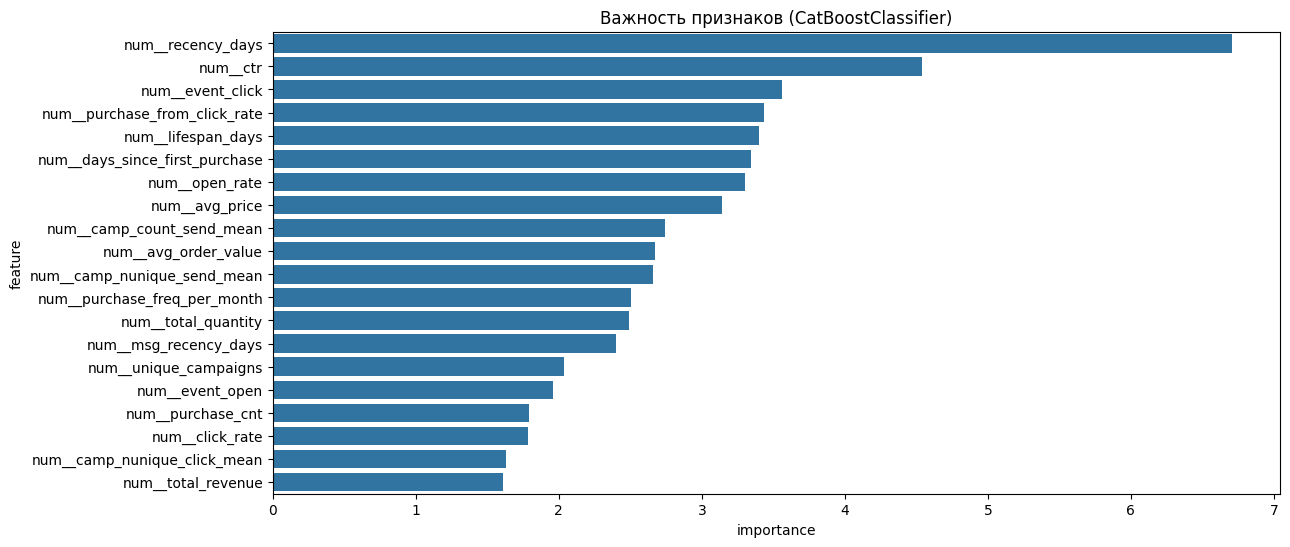

Топ-20 важных признаков:
                           feature  importance
7                num__recency_days    6.708940
85                        num__ctr    4.536916
70                num__event_click    3.563920
86   num__purchase_from_click_rate    3.436596
9               num__lifespan_days    3.399103
8   num__days_since_first_purchase    3.345729
83                  num__open_rate    3.302705
3                   num__avg_price    3.143466
19       num__camp_count_send_mean    2.743533
2             num__avg_order_value    2.671337
28     num__camp_nunique_send_mean    2.655924
10    num__purchase_freq_per_month    2.506973
5              num__total_quantity    2.489264
88           num__msg_recency_days    2.397402
12           num__unique_campaigns    2.033317
75                 num__event_open    1.956536
0                num__purchase_cnt    1.790148
84                 num__click_rate    1.786446
23    num__camp_nunique_click_mean    1.627276
1               num__total_revenue 

In [182]:
# feature importance (стандартная)
if hasattr(model, 'feature_importances_'):
    importance = model.feature_importances_
        
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    }).sort_values('importance', ascending=False)
        
    plt.figure(figsize=(13, 6))
    sns.barplot(x='importance', y='feature', data=importance_df.head(20))
    plt.title(f'Важность признаков ({best_model_metrics["model_name"]})')
    plt.show()
        
    print("Топ-20 важных признаков:")
    print(importance_df.head(20))
else:
    print(f"Модель {model_name} не имеет атрибута feature_importances_")


SHAP анализ для CatBoostClassifier:
Используется TreeExplainer для CatBoostClassifier


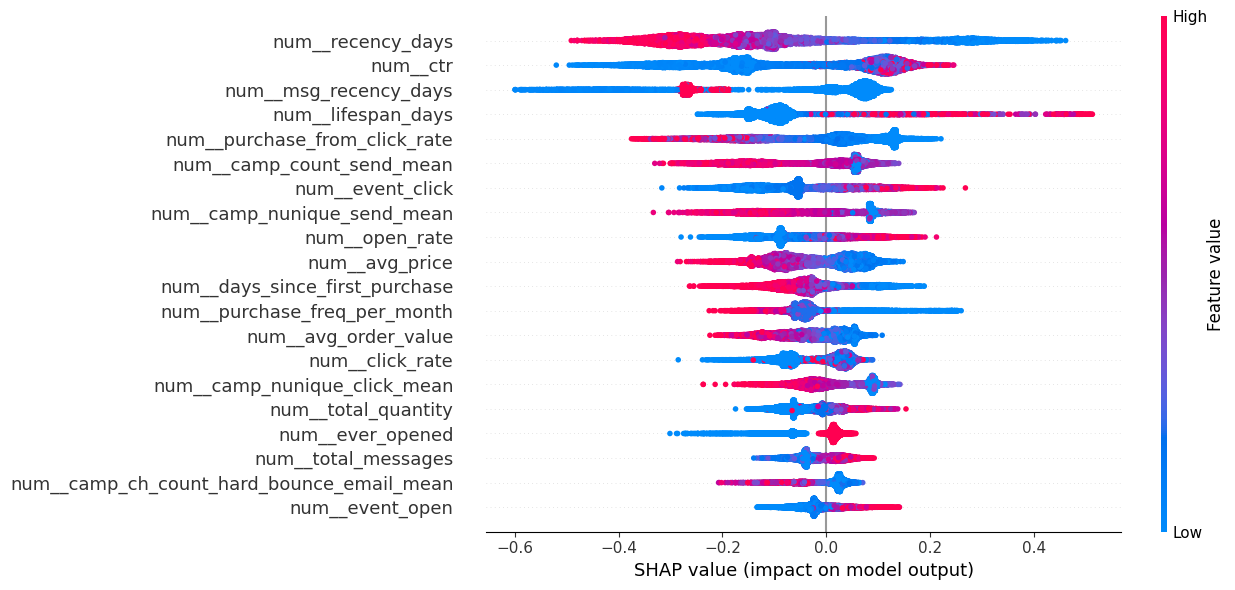

In [ ]:
print(f"\nSHAP анализ для {best_model_metrics['model_name']}:")
try:
    if any(tree_model in model_name for tree_model in 
           ['RandomForest', 'DecisionTree', 'XGB', 'LGBM', 'CatBoost', 'GradientBoosting']):
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_sample)  
    elif 'LogisticRegression' in model_name:
        explainer = shap.LinearExplainer(model, X_sample)
        shap_values = explainer.shap_values(X_sample)
    else:
        explainer = shap.Explainer(model, X_sample)
        shap_values = explainer(X_sample)
    
    # summary plot
    shap.summary_plot(shap_values, X_sample, feature_names=feature_names, show=False)
    plt.gcf().set_size_inches(13, 6)
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Ошибка при SHAP анализе: {str(e)}")

In [186]:
# Обработка разных форматов shap_values
if isinstance(shap_values, list):
    # Для мультиклассовой классификации берем значения для класса 1
    if len(shap_values) == 2:
        shap_values_processed = shap_values[1]  # для бинарной классификации
    else:
        shap_values_processed = shap_values
else:
    shap_values_processed = shap_values

# Вычисляем важность признаков (средняя абсолютная величина SHAP)
if len(shap_values_processed.shape) == 2:
    # Стандартный случай: (n_samples, n_features)
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': np.abs(shap_values_processed).mean(axis=0)
    })
else:
    # Если другая структура
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': np.abs(shap_values_processed).mean(axis=0)
    })

# Сортируем по важности
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Выводим топ-20 признаков
print("\n" + "="*60)
print("ТОП-20 ВАЖНЕЙШИХ ПРИЗНАКОВ ПО SHAP:")
print("="*60)

for i, row in feature_importance.head(20).iterrows():
    print(f"{i+1:2d}. {row['feature']:35} | Важность: {row['importance']:.4f}")


ТОП-20 ВАЖНЕЙШИХ ПРИЗНАКОВ ПО SHAP:
 8. num__recency_days                   | Важность: 0.1984
86. num__ctr                            | Важность: 0.1564
89. num__msg_recency_days               | Важность: 0.1294
10. num__lifespan_days                  | Важность: 0.1129
87. num__purchase_from_click_rate       | Важность: 0.1001
20. num__camp_count_send_mean           | Важность: 0.0910
71. num__event_click                    | Важность: 0.0907
29. num__camp_nunique_send_mean         | Важность: 0.0887
84. num__open_rate                      | Важность: 0.0749
 4. num__avg_price                      | Важность: 0.0693
 9. num__days_since_first_purchase      | Важность: 0.0620
11. num__purchase_freq_per_month        | Важность: 0.0569
 3. num__avg_order_value                | Важность: 0.0517
85. num__click_rate                     | Важность: 0.0517
24. num__camp_nunique_click_mean        | Важность: 0.0484
 6. num__total_quantity                 | Важность: 0.0460
92. num__ever_opene

Топ-20 признаков для отбора (после очистки префиксов):
 1. recency_days
 2. ctr
 3. msg_recency_days
 4. lifespan_days
 5. purchase_from_click_rate
 6. camp_count_send_mean
 7. event_click
 8. camp_nunique_send_mean
 9. open_rate
10. avg_price
11. days_since_first_purchase
12. purchase_freq_per_month
13. avg_order_value
14. click_rate
15. camp_nunique_click_mean
16. total_quantity
17. ever_opened
18. total_messages
19. camp_ch_count_hard_bounce_email_mean
20. event_open

Переобучение CatBoostClassifier на топ-20 признаках...

Метрики на тестовой выборке для модели с топ-20 признаками:
Accuracy: 0.8941
Precision: 0.0631
Recall: 0.3250
F1-score: 0.1057
F2-score: 0.1776
ROC-AUC: 0.7432
Average Precision: 0.0627

Матрица ошибок (топ-20 признаков):
[[11065  1158]
 [  162    78]]


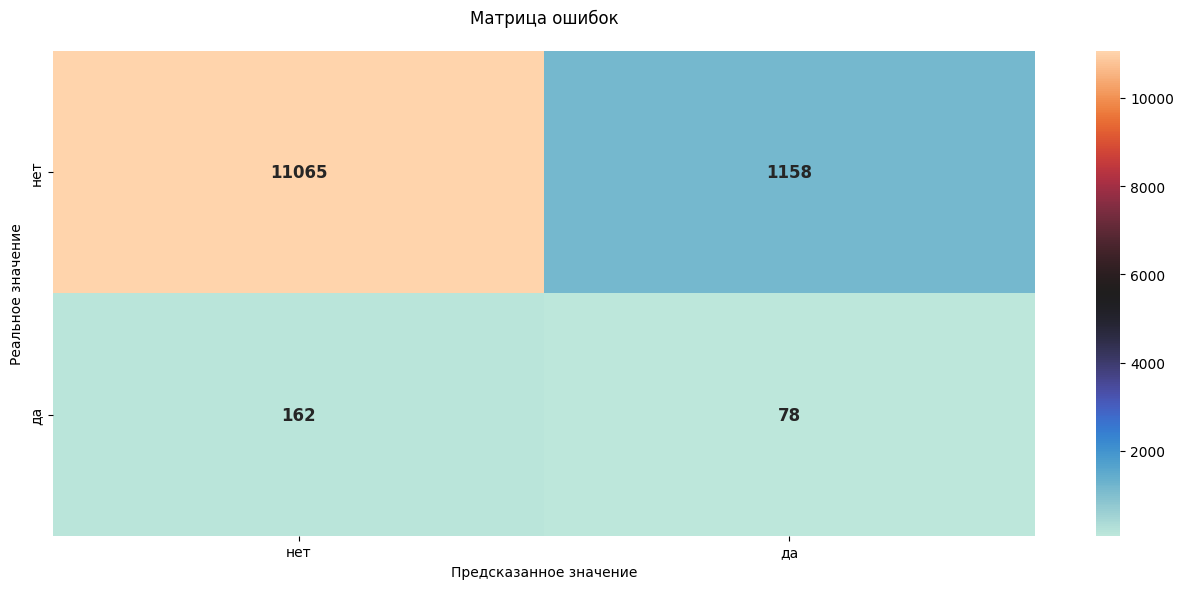

Интерпретация:
  Правильно предсказано 'нет' (True Negative): 11065
  Ложно предсказано 'да' (False Positive): 1158
  Ложно предсказано 'нет' (False Negative): 162
  Правильно предсказано 'да' (True Positive): 78


In [ ]:
# Получаем список топ-20 признаков из SHAP анализа
top_20_features = feature_importance.head(20)['feature'].tolist()

# Убираем префиксы 'num__' и 'cat__' из названий признаков
top_20_features_clean = [feature.replace('num__', '').replace('cat__', '') for feature in top_20_features]

print("Топ-20 признаков для отбора (после очистки префиксов):")
for i, feature in enumerate(top_20_features_clean, 1):
    print(f"{i:2d}. {feature}")

# Получаем классификатор из исходного пайплайна
original_classifier = best_final_model.named_steps['model']

# Создаем новый ColumnTransformer только для выбранных признаков
preprocessor_top20 = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), top_20_features_clean)
    ],
    remainder='drop'  # ВАЖНО: отбрасываем все остальные признаки
)

# Создаем новый пайплайн
model_top20 = Pipeline([
    ('preprocessor', preprocessor_top20),
    ('classifier', type(original_classifier)(**original_classifier.get_params()))
])

print(f"\nПереобучение {best_model_metrics['model_name']} на топ-20 признаках...")

# Обучаем на сокращенном наборе признаков
model_top20.fit(X_train[top_20_features_clean], y_train)

# Предсказания на тестовой выборке
y_pred_top20 = model_top20.predict(X_test[top_20_features_clean])
y_pred_proba_top20 = model_top20.predict_proba(X_test[top_20_features_clean])[:, 1]

# Дальше твой код с метриками...
accuracy_top20 = accuracy_score(y_test, y_pred_top20)
precision_top20 = precision_score(y_test, y_pred_top20)
recall_top20 = recall_score(y_test, y_pred_top20)
f1_top20 = f1_score(y_test, y_pred_top20)
f2_top20 = fbeta_score(y_test, y_pred_top20, beta=2)
roc_auc_top20 = roc_auc_score(y_test, y_pred_proba_top20)
average_precision_top20 = average_precision_score(y_test, y_pred_proba_top20)

print(f"\nМетрики на тестовой выборке для модели с топ-20 признаками:")
print(f"Accuracy: {accuracy_top20:.4f}")
print(f"Precision: {precision_top20:.4f}")
print(f"Recall: {recall_top20:.4f}")
print(f"F1-score: {f1_top20:.4f}")
print(f"F2-score: {f2_top20:.4f}")
print(f"ROC-AUC: {roc_auc_top20:.4f}")
print(f"Average Precision: {average_precision_top20:.4f}")

# Матрица ошибок для модели с топ-20
print("\nМатрица ошибок (топ-20 признаков):")
cm_top20 = confusion_matrix(y_test, y_pred_top20)
print(cm_top20)
plot_confusion_matrix(cm_top20)

## <u>Итоговый вывод</u>